In [1]:
import os
import zipfile
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import sys
import warnings
import time
warnings.filterwarnings("ignore")

start_time = time.time()

try:
    import wandb
    WANDB_AVAILABLE = True
    # wandb.init(project="xLSTM-MovieLens1M", name="xLSTM-run-50max_len", config={"epochs": 10})
except ImportError:
    WANDB_AVAILABLE = False

sys.path.append("../..")
from xlstm.xlstm_large.model import xLSTMLargeConfig, xLSTMLarge

# -----------------------------
# 1. Download MovieLens 100K
# -----------------------------
DATA_URL = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
DATA_DIR = "ml-100k"

if not os.path.exists(DATA_DIR):
    print("Downloading MovieLens 100K dataset...")
    r = requests.get(DATA_URL)
    with open("ml-100k.zip", "wb") as f:
        f.write(r.content)
    with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Extraction complete.")

# -----------------------------
# 2. Load and Preprocess Data
# -----------------------------
# Read ratings
rating_df = pd.read_csv(os.path.join(DATA_DIR, "u.data"), sep="\t", engine='python',
                        names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Load movies
movies = pd.read_csv(os.path.join(DATA_DIR, "u.item"), sep='|', encoding='latin-1', header=None, engine='python',
                     names=['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
                            'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                            'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                            'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

# Load users
users = pd.read_csv(os.path.join(DATA_DIR, "u.user"), sep='|', header=None,
                    names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

# Sort by user and time
rating_df.sort_values(by=['user_id', 'timestamp'], inplace=True)

# Create ID mappings
user2id = {uid: i for i, uid in enumerate(rating_df['user_id'].unique())}
item2id = {iid: i for i, iid in enumerate(rating_df['movie_id'].unique())}

# Map IDs
rating_df['user_id'] = rating_df['user_id'].map(user2id)
rating_df['movie_id'] = rating_df['movie_id'].map(item2id)

# Map IDs in user and movie tables too
users['user_id'] = users['user_id'].map(user2id)
movies['movie_id'] = movies['movie_id'].map(item2id)

# Drop users/movies with NaN after mapping
users.dropna(subset=['user_id'], inplace=True)
movies.dropna(subset=['movie_id'], inplace=True)

# Convert to int
users['user_id'] = users['user_id'].astype(int)
movies['movie_id'] = movies['movie_id'].astype(int)

# Merge metadata into ratings
rating_df = rating_df.merge(users, on='user_id', how='left')
rating_df = rating_df.merge(movies, on='movie_id', how='left')

# Set final counts
num_users = len(user2id)
num_items = len(item2id)

print(f"Length of the ratings: {len(rating_df)}")
print(f"Shape of the ratings dataframe: {rating_df.shape}")
print(rating_df.head())
print(user2id)
print(item2id)
print(num_users)
print(num_items)

# -----------------------------
# Step 1: Build Feature Dictionaries
# -----------------------------
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

def normalize_timestamp(ts):
    return float(ts) / 1e9

movie_feat_dict = {}
for movie_id, group in rating_df.groupby('movie_id'):
    row = group.iloc[0]
    timestamp = normalize_timestamp(row['timestamp'])
    genres = row[genre_columns].values.astype(np.float32)
    feature_vector = np.concatenate([[timestamp], genres])
    movie_feat_dict[movie_id] = feature_vector

feature_dim = len(next(iter(movie_feat_dict.values())))

# -----------------------------
# Step 2: Construct Sequence Splits
# -----------------------------
train_seqs, val_seqs, test_seqs = {}, {}, {}
for uid, group in rating_df.groupby('user_id'):
    items = group['movie_id'].tolist()
    if len(items) < 3:
        continue
    train_seqs[uid] = items[:-2]
    val_seqs[uid] = [(items[:i], items[i]) for i in range(1, len(items) - 1)]
    test_seqs[uid] = [(items[:-1], items[-1])]

# -----------------------------
# Step 3: Dataset Classes
# -----------------------------
class TrainDataset(Dataset):
    def __init__(self, sequences, max_len=50):
        self.samples = []
        for uid, items in sequences.items():
            for i in range(1, len(items)):
                seq = items[max(0, i - max_len):i]
                target = items[i]
                self.samples.append((seq, target))
        self.max_len = max_len
        print(f"Train samples: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq, target = self.samples[idx]
        padded_seq = [0] * (self.max_len - len(seq)) + seq
        seq_features = [movie_feat_dict.get(mid, np.zeros(feature_dim)) for mid in padded_seq]
        target_feat = movie_feat_dict.get(target, np.zeros(feature_dim))
        return torch.tensor(seq_features, dtype=torch.float32), torch.tensor(target_feat, dtype=torch.float32)

class TestDataset(Dataset):
    def __init__(self, sequences, max_len=50):
        self.samples = []
        for uid, pairs in sequences.items():
            for seq, tgt in pairs:
                seq = seq[-max_len:]
                self.samples.append((seq, tgt))
        self.max_len = max_len

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq, target = self.samples[idx]
        padded_seq = [0] * (self.max_len - len(seq)) + seq
        seq_features = [movie_feat_dict.get(mid, np.zeros(feature_dim)) for mid in padded_seq]
        target_feat = movie_feat_dict.get(target, np.zeros(feature_dim))
        return torch.tensor(seq_features, dtype=torch.float32), torch.tensor(target_feat, dtype=torch.float32)

class EvalDataset(Dataset):
    def __init__(self, sequences, max_len=50):
        self.samples = []
        for uid, pairs in sequences.items():
            for seq, tgt in pairs:
                seq = seq[-max_len:]
                self.samples.append((uid, seq, tgt))
        self.max_len = max_len

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        uid, seq, target = self.samples[idx]
        padded_seq = [0] * (self.max_len - len(seq)) + seq
        seq_features = [movie_feat_dict.get(mid, np.zeros(feature_dim)) for mid in padded_seq]
        target_feat = movie_feat_dict.get(target, np.zeros(feature_dim))
        return torch.tensor(uid), torch.tensor(seq_features, dtype=torch.float32), torch.tensor(target_feat, dtype=torch.float32)


# -----------------------------
# Inspect train/val/test sequences
# -----------------------------

train_dataset = TrainDataset(train_seqs)

seq, target = train_dataset[0]
print("\n[DEBUG] Input sequence shape:", seq.shape)
print("[DEBUG] Example feature vector at t=0:", seq[0])
print("[DEBUG] Target vector:", target)


print("\n[INFO] Sample from train_seqs:")
for uid in list(train_seqs.keys())[0:4]:  # Show 3 users (UIDs 1 to 3)
    print(f"\nUser ID: {uid}")
    print(f"Train sequence (movie_ids): {train_seqs[uid]}")
    print(f"Sequence length: {len(train_seqs[uid])}")

print("\n[INFO] Sample from val_seqs:")
for uid in list(val_seqs.keys())[0:4]:  # Show 3 users (UIDs 1 to 3)
    print(f"\nUser ID: {uid}")
    print("Validation samples (prefix -> target):")
    for prefix, target in val_seqs[uid][:3]:  # Show first 3 (prefix, target) pairs
        print(f"  {prefix} -> {target}")

print("\n[INFO] Sample from test_seqs:")
for uid in list(test_seqs.keys())[0:4]:  # Show 3 users (UIDs 1 to 3)
    print(f"\nUser ID: {uid}")
    prefix, target = test_seqs[uid][0]  # Only one test pair per user
    print(f"Test prefix: {prefix}")
    print(f"Test target: {target}")


# -----------------------------
# Step 4: DataLoaders
# -----------------------------
train_loader = DataLoader(TrainDataset(train_seqs), batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(EvalDataset(val_seqs), batch_size=256)
test_loader = DataLoader(EvalDataset(test_seqs), batch_size=256)


inputs, targets = next(iter(train_loader))

print("[DEBUG] Input batch shape:", inputs.shape)    # (batch_size, max_len, feature_dim)
print("[DEBUG] Target batch shape:", targets.shape)  # (batch_size, feature_dim)

# Optional: print first sample
print("[DEBUG] First input sequence shape:", inputs[0].shape)
print("[DEBUG] First target vector:", targets[0])


# -----------------------------
# 4. Model Setup
# -----------------------------
xlstm_config = xLSTMLargeConfig(
    embedding_dim=128,
    num_heads=2,
    num_blocks=2,
    vocab_size=num_items + 1,
    return_last_states=True,
    mode="inference",
    chunkwise_kernel="chunkwise--triton_xl_chunk",
    sequence_kernel="native_sequence__triton",
    step_kernel="triton",
)

if WANDB_AVAILABLE:
    wandb.init(
        project="xLSTM-MovieLens100K",
        name="val-and-lr-scheduler-30epochs",
        notes="1 feature, with val, 2 blocks, 2 heads,100K. Uses validation + LR scheduler. Max_len 50, Embd 128.",

        config={
            "epochs": 30,
            "train_batch_size": 256,
            "val_batch_size": 256,
            "max_len": 50,
            "embedding_dim": 128,
            "num_heads": 2,
            "num_blocks": 2,
            "learning_rate": 0.001,
            "num_users": num_users,
            "num_items": num_items,
            "dataset": "MovieLens-100K",
            "loss_fn": "CrossEntropyLoss"
        }
    )

model = xLSTMLarge(xlstm_config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"\nUsing device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# -----------------------------
# 5. Metrics
# -----------------------------
def recall_mrr_ndcg_k(preds, targets, k=10):
    recall, mrr, ndcg = 0.0, 0.0, 0.0
    for pred, target in zip(preds, targets):
        if target in pred[:k]:
            rank = pred[:k].index(target)
            recall += 1
            mrr += 1.0 / (rank + 1)
            ndcg += 1.0 / np.log2(rank + 2)
    n = len(preds)
    return recall / n, mrr / n, ndcg / n

# -----------------------------
# 6. Training
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
recall_list, mrr_list, ndcg_list = [], [], []

print("\nStarting training...")
for epoch in range(10):
    model.train()
    total_loss = 0
    for seqs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        seqs, targets = seqs.to(device), targets.to(device)
        optimizer.zero_grad()
        logits = model(seqs)[0]
        if logits.dim() == 3:
            logits = logits[:, -1, :]
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Evaluate on test set
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for _, seqs, targets in test_loader:  # <- FIXED LINE
            seqs = seqs.to(device)
            logits = model(seqs)[0]
            if logits.dim() == 3:
                logits = logits[:, -1, :]
            topk = torch.topk(logits, k=10, dim=-1).indices.cpu().tolist()
            all_preds.extend(topk)
            all_targets.extend(targets.tolist())


    recall, mrr, ndcg = recall_mrr_ndcg_k(all_preds, all_targets)
    recall_list.append(recall)
    mrr_list.append(mrr)
    ndcg_list.append(ndcg)

    print(f"Epoch {epoch+1} | Loss: {total_loss:.2f} | Recall@10: {recall:.4f} | MRR@10: {mrr:.4f} | NDCG@10: {ndcg:.4f}")
    if WANDB_AVAILABLE:
        wandb.log({"loss": total_loss, "recall@10": recall, "mrr@10": mrr, "ndcg@10": ndcg})

# -----------------------------
# 7. Plot
# -----------------------------
plt.figure()
plt.plot(recall_list, label='Recall@10')
plt.plot(mrr_list, label='MRR@10')
plt.plot(ndcg_list, label='NDCG@10')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Test Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

elapsed_minutes = (time.time() - start_time) / 60
print(f"\nTotal run time: {elapsed_minutes:.2f} minutes")

# -----------------------------
# 8. Sample Predictions
# -----------------------------
sample_dataset = EvalDataset(test_seqs, max_len=50)
sample_loader = DataLoader(sample_dataset, batch_size=1, shuffle=True)

with torch.no_grad():
    for i, (uid_tensor, seq_tensor, target_tensor) in enumerate(sample_loader):
        uid = uid_tensor.item()
        input_seq = seq_tensor.to(device)
        target = target_tensor.item()

        logits = model(input_seq)[0]
        if logits.dim() == 3:
            logits = logits[:, -1, :]

        probs = torch.softmax(logits, dim=-1)
        topk_logits = torch.topk(logits, k=10, dim=-1)
        topk_probs = torch.topk(probs, k=10, dim=-1)

        topk_items = topk_probs.indices.squeeze().tolist()
        topk_scores = topk_probs.values.squeeze().tolist()
        topk_raw_logits = topk_logits.values.squeeze().tolist()

        input_ids = seq_tensor.squeeze().tolist()
        print(f"\nUser ID: {uid}")
        print("Input sequence:")
        for m in input_ids:
            if m > 0:
                print(f"  - Item {m}: {movie_titles.get(m, 'Unknown')}")

        true_movie = movie_titles.get(target, f"Item {target}")
        true_prob = probs[0, target].item()
        true_logit = logits[0, target].item()
        print(f"True next item: Item {target}: {true_movie} (logit: {true_logit:.4f}, confidence: {true_prob:.4f})")

        print("Top-10 Predictions with scores:")
        for rank, (item, logit_score, prob_score) in enumerate(zip(topk_items, topk_raw_logits, topk_scores), start=1):
            movie_name = movie_titles.get(item, f"Item {item}")
            print(f"  {rank}. Item {item}: {movie_name} (logit: {logit_score:.4f}, confidence: {prob_score:.4f})")

        if i == 4:
            break

Length of the ratings: 100000
Shape of the ratings dataframe: (100000, 31)
   user_id  movie_id  rating  timestamp  age gender  occupation zip_code  \
0        0         0       5  874965478   24      M  technician    85711   
1        0         1       5  874965478   24      M  technician    85711   
2        0         2       5  874965518   24      M  technician    85711   
3        0         3       4  874965556   24      M  technician    85711   
4        0         4       5  874965677   24      M  technician    85711   

                                    title release_date  ...  Fantasy  \
0  Monty Python and the Holy Grail (1974)  01-Jan-1974  ...        0   
1         Empire Strikes Back, The (1980)  01-Jan-1980  ...        0   
2                 Jean de Florette (1986)  01-Jan-1986  ...        0   
3                   Reservoir Dogs (1992)  01-Jan-1992  ...        0   
4               Dead Poets Society (1989)  01-Jan-1989  ...        0   

  Film-Noir  Horror  Musical  Myste

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: qubits-learner (qubits-learner-johannes-kepler-universit-t-linz) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.47 GB

Starting training...


Epoch 1:   0%|          | 0/380 [00:00<?, ?it/s]


AssertionError: Input must have shape [B, S], got torch.Size([256, 50, 20])

In [11]:
import os
import zipfile
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import sys
import warnings
import time
warnings.filterwarnings("ignore")

start_time = time.time()

try:
    import wandb
    WANDB_AVAILABLE = True
    # wandb.init(project="xLSTM-MovieLens1M", name="xLSTM-run-50max_len", config={"epochs": 10})


except ImportError:
    WANDB_AVAILABLE = False

sys.path.append("../..")
from xlstm.xlstm_large.model import xLSTMLargeConfig, xLSTMLarge

# -----------------------------
# 1. Download MovieLens 100K
# -----------------------------
DATA_URL = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
DATA_DIR = "ml-100k"

if not os.path.exists(DATA_DIR):
    print("Downloading MovieLens 100K dataset...")
    r = requests.get(DATA_URL)
    with open("ml-100k.zip", "wb") as f:
        f.write(r.content)
    with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Extraction complete.")


# 2------------------------------------------
import pandas as pd
import os

# Read ratings
rating_df = pd.read_csv(os.path.join(DATA_DIR, "u.data"), sep="\t", engine='python',
                        names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Load movies
movies = pd.read_csv(os.path.join(DATA_DIR, "u.item"), sep='|', encoding='latin-1', header=None, engine='python',
                     names=['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
                            'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                            'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                            'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

# Load users
users = pd.read_csv(os.path.join(DATA_DIR, "u.user"), sep='|', header=None,
                    names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

# Sort by user and time
rating_df.sort_values(by=['user_id', 'timestamp'], inplace=True)

# Create ID mappings
user2id = {uid: i for i, uid in enumerate(rating_df['user_id'].unique())}
item2id = {iid: i for i, iid in enumerate(rating_df['movie_id'].unique())}

# Map IDs
rating_df['user_id'] = rating_df['user_id'].map(user2id)
rating_df['movie_id'] = rating_df['movie_id'].map(item2id)

# Map IDs in user and movie tables too
users['user_id'] = users['user_id'].map(user2id)
movies['movie_id'] = movies['movie_id'].map(item2id)

# Drop users/movies with NaN after mapping (e.g., not present in ratings)
users.dropna(subset=['user_id'], inplace=True)
movies.dropna(subset=['movie_id'], inplace=True)

# Convert IDs to integer
users['user_id'] = users['user_id'].astype(int)
movies['movie_id'] = movies['movie_id'].astype(int)

# Merge metadata into ratings
rating_df = rating_df.merge(users, on='user_id', how='left')
rating_df = rating_df.merge(movies, on='movie_id', how='left')



# -----------------------------
# 2. Load and split data (with validation)
# -----------------------------
# print("\nLoading and splitting data...")
# rating_df = pd.read_csv(os.path.join(DATA_DIR, "u.data"), sep="\t", engine='python',
#                         names=['user_id', 'movie_id', 'rating', 'timestamp'])

# # url_base = "https://files.grouplens.org/datasets/movielens/ml-100k/"
# # df = pd.read_csv(url_base + "u.data", sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

# # movies = pd.read_csv(url_base + "u.item", sep='|', encoding='latin-1', header=None, engine='python',
# #                       names=['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
# #                              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
# #                              'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
# #                              'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

# # users = pd.read_csv(url_base + "u.user", sep='|', header=None,
# #                      names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
# # print("Data loaded in", round((time.time() - start)/60, 2), "minutes")
# # print(df.head())

# rating_df.sort_values(by=['user_id', 'timestamp'], inplace=True)
# user2id = {uid: i for i, uid in enumerate(rating_df['user_id'].unique())}
# item2id = {iid: i for i, iid in enumerate(rating_df['movie_id'].unique())}
# rating_df['user_id'] = rating_df['user_id'].map(user2id)
# rating_df['movie_id'] = rating_df['movie_id'].map(item2id)

# num_users = len(user2id)
# num_items = len(item2id)

print(f"Length of the ratings: {len(rating_df)}")
print(f"Shape of the ratings dataframe: {rating_df.shape}")
display(rating_df.head())
print(user2id)
print(item2id)
print(num_users)
print(num_items)

Length of the ratings: 100000
Shape of the ratings dataframe: (100000, 31)


,user_id,movie_id,rating,timestamp,age,gender,occupation,zip_code,title,release_date,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,5,874965478,24,M,technician,85711,Monty Python and the Holy Grail (1974),01-Jan-1974,...,0,0,0,0,0,0,0,0,0,0
1,0,1,5,874965478,24,M,technician,85711,"Empire Strikes Back, The (1980)",01-Jan-1980,...,0,0,0,0,0,1,1,0,1,0
2,0,2,5,874965518,24,M,technician,85711,Jean de Florette (1986),01-Jan-1986,...,0,0,0,0,0,0,0,0,0,0
3,0,3,4,874965556,24,M,technician,85711,Reservoir Dogs (1992),01-Jan-1992,...,0,0,0,0,0,0,0,1,0,0
4,0,4,5,874965677,24,M,technician,85711,Dead Poets Society (1989),01-Jan-1989,...,0,0,0,0,0,0,0,0,0,0


{np.int64(1): 0, np.int64(2): 1, np.int64(3): 2, np.int64(4): 3, np.int64(5): 4, np.int64(6): 5, np.int64(7): 6, np.int64(8): 7, np.int64(9): 8, np.int64(10): 9, np.int64(11): 10, np.int64(12): 11, np.int64(13): 12, np.int64(14): 13, np.int64(15): 14, np.int64(16): 15, np.int64(17): 16, np.int64(18): 17, np.int64(19): 18, np.int64(20): 19, np.int64(21): 20, np.int64(22): 21, np.int64(23): 22, np.int64(24): 23, np.int64(25): 24, np.int64(26): 25, np.int64(27): 26, np.int64(28): 27, np.int64(29): 28, np.int64(30): 29, np.int64(31): 30, np.int64(32): 31, np.int64(33): 32, np.int64(34): 33, np.int64(35): 34, np.int64(36): 35, np.int64(37): 36, np.int64(38): 37, np.int64(39): 38, np.int64(40): 39, np.int64(41): 40, np.int64(42): 41, np.int64(43): 42, np.int64(44): 43, np.int64(45): 44, np.int64(46): 45, np.int64(47): 46, np.int64(48): 47, np.int64(49): 48, np.int64(50): 49, np.int64(51): 50, np.int64(52): 51, np.int64(53): 52, np.int64(54): 53, np.int64(55): 54, np.int64(56): 55, np.int64(5


Loading and splitting data...
Train samples: 97171


loss,█▄▃▂▁
mrr@10,▁▄▇█▄
ndcg@10,▁▄██▆
recall@10,▁▅█▇█
loss,2058.48628
mrr@10,0.03386
ndcg@10,0.05158
recall@10,0.11135



Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.47 GB

Starting training...


Epoch 1: 100%|██████████| 380/380 [00:10<00:00, 36.10it/s]


Epoch 1 | Loss: 2528.26 | Recall@10: 0.0848 | MRR@10: 0.0346 | NDCG@10: 0.0463


Epoch 2: 100%|██████████| 380/380 [00:10<00:00, 34.86it/s]


Epoch 2 | Loss: 2291.71 | Recall@10: 0.1092 | MRR@10: 0.0349 | NDCG@10: 0.0519


Epoch 3: 100%|██████████| 380/380 [00:10<00:00, 36.41it/s]


Epoch 3 | Loss: 2209.16 | Recall@10: 0.1060 | MRR@10: 0.0387 | NDCG@10: 0.0543


Epoch 4: 100%|██████████| 380/380 [00:10<00:00, 36.17it/s]


Epoch 4 | Loss: 2134.42 | Recall@10: 0.1177 | MRR@10: 0.0415 | NDCG@10: 0.0590


Epoch 5: 100%|██████████| 380/380 [00:10<00:00, 36.85it/s]


Epoch 5 | Loss: 2060.11 | Recall@10: 0.1113 | MRR@10: 0.0449 | NDCG@10: 0.0603


Epoch 6: 100%|██████████| 380/380 [00:10<00:00, 35.38it/s]


Epoch 6 | Loss: 1986.13 | Recall@10: 0.1029 | MRR@10: 0.0416 | NDCG@10: 0.0558


Epoch 7: 100%|██████████| 380/380 [00:10<00:00, 34.77it/s]


Epoch 7 | Loss: 1910.18 | Recall@10: 0.0923 | MRR@10: 0.0370 | NDCG@10: 0.0497


Epoch 8: 100%|██████████| 380/380 [00:10<00:00, 34.98it/s]


Epoch 8 | Loss: 1831.03 | Recall@10: 0.1018 | MRR@10: 0.0338 | NDCG@10: 0.0495


Epoch 9: 100%|██████████| 380/380 [00:10<00:00, 34.69it/s]


Epoch 9 | Loss: 1753.39 | Recall@10: 0.0944 | MRR@10: 0.0394 | NDCG@10: 0.0522


Epoch 10: 100%|██████████| 380/380 [00:10<00:00, 34.82it/s]


Epoch 10 | Loss: 1677.88 | Recall@10: 0.1018 | MRR@10: 0.0364 | NDCG@10: 0.0514


Epoch 11: 100%|██████████| 380/380 [00:11<00:00, 32.81it/s]


Epoch 11 | Loss: 1606.46 | Recall@10: 0.0965 | MRR@10: 0.0367 | NDCG@10: 0.0505


Epoch 12: 100%|██████████| 380/380 [00:10<00:00, 35.00it/s]


Epoch 12 | Loss: 1540.81 | Recall@10: 0.0901 | MRR@10: 0.0350 | NDCG@10: 0.0477


Epoch 13: 100%|██████████| 380/380 [00:10<00:00, 35.55it/s]


Epoch 13 | Loss: 1479.27 | Recall@10: 0.0891 | MRR@10: 0.0329 | NDCG@10: 0.0460


Epoch 14: 100%|██████████| 380/380 [00:10<00:00, 35.29it/s]


Epoch 14 | Loss: 1423.70 | Recall@10: 0.0901 | MRR@10: 0.0307 | NDCG@10: 0.0443


Epoch 15: 100%|██████████| 380/380 [00:10<00:00, 34.93it/s]


Epoch 15 | Loss: 1374.76 | Recall@10: 0.0838 | MRR@10: 0.0318 | NDCG@10: 0.0437


Epoch 16: 100%|██████████| 380/380 [00:10<00:00, 34.74it/s]


Epoch 16 | Loss: 1328.19 | Recall@10: 0.0785 | MRR@10: 0.0291 | NDCG@10: 0.0404


Epoch 17: 100%|██████████| 380/380 [00:11<00:00, 34.37it/s]


Epoch 17 | Loss: 1286.37 | Recall@10: 0.0742 | MRR@10: 0.0281 | NDCG@10: 0.0387


Epoch 18: 100%|██████████| 380/380 [00:11<00:00, 34.39it/s]


Epoch 18 | Loss: 1249.92 | Recall@10: 0.0764 | MRR@10: 0.0292 | NDCG@10: 0.0401


Epoch 19: 100%|██████████| 380/380 [00:10<00:00, 34.72it/s]


Epoch 19 | Loss: 1216.24 | Recall@10: 0.0700 | MRR@10: 0.0293 | NDCG@10: 0.0387


Epoch 20: 100%|██████████| 380/380 [00:11<00:00, 34.53it/s]


Epoch 20 | Loss: 1187.30 | Recall@10: 0.0753 | MRR@10: 0.0239 | NDCG@10: 0.0358


Epoch 21: 100%|██████████| 380/380 [00:10<00:00, 34.64it/s]


Epoch 21 | Loss: 1157.25 | Recall@10: 0.0732 | MRR@10: 0.0272 | NDCG@10: 0.0377


Epoch 22: 100%|██████████| 380/380 [00:10<00:00, 34.65it/s]


Epoch 22 | Loss: 1132.76 | Recall@10: 0.0774 | MRR@10: 0.0281 | NDCG@10: 0.0395


Epoch 23: 100%|██████████| 380/380 [00:11<00:00, 34.04it/s]


Epoch 23 | Loss: 1108.09 | Recall@10: 0.0764 | MRR@10: 0.0269 | NDCG@10: 0.0383


Epoch 24: 100%|██████████| 380/380 [00:11<00:00, 34.45it/s]


Epoch 24 | Loss: 1085.93 | Recall@10: 0.0774 | MRR@10: 0.0265 | NDCG@10: 0.0383


Epoch 25: 100%|██████████| 380/380 [00:11<00:00, 34.49it/s]


Epoch 25 | Loss: 1065.59 | Recall@10: 0.0636 | MRR@10: 0.0251 | NDCG@10: 0.0340


Epoch 26: 100%|██████████| 380/380 [00:11<00:00, 34.52it/s]


Epoch 26 | Loss: 1043.96 | Recall@10: 0.0710 | MRR@10: 0.0265 | NDCG@10: 0.0367


Epoch 27: 100%|██████████| 380/380 [00:10<00:00, 36.45it/s]


Epoch 27 | Loss: 1025.50 | Recall@10: 0.0742 | MRR@10: 0.0315 | NDCG@10: 0.0415


Epoch 28: 100%|██████████| 380/380 [00:10<00:00, 36.95it/s]


Epoch 28 | Loss: 1008.27 | Recall@10: 0.0742 | MRR@10: 0.0271 | NDCG@10: 0.0380


Epoch 29: 100%|██████████| 380/380 [00:10<00:00, 36.30it/s]


Epoch 29 | Loss: 994.70 | Recall@10: 0.0636 | MRR@10: 0.0263 | NDCG@10: 0.0349


Epoch 30: 100%|██████████| 380/380 [00:10<00:00, 36.96it/s]


Epoch 30 | Loss: 980.65 | Recall@10: 0.0647 | MRR@10: 0.0259 | NDCG@10: 0.0349


Epoch 31: 100%|██████████| 380/380 [00:10<00:00, 36.81it/s]


Epoch 31 | Loss: 969.55 | Recall@10: 0.0710 | MRR@10: 0.0241 | NDCG@10: 0.0349


Epoch 32: 100%|██████████| 380/380 [00:10<00:00, 37.35it/s]


Epoch 32 | Loss: 954.67 | Recall@10: 0.0710 | MRR@10: 0.0236 | NDCG@10: 0.0346


Epoch 33: 100%|██████████| 380/380 [00:10<00:00, 37.34it/s]


Epoch 33 | Loss: 944.59 | Recall@10: 0.0742 | MRR@10: 0.0253 | NDCG@10: 0.0367


Epoch 34: 100%|██████████| 380/380 [00:10<00:00, 35.51it/s]


Epoch 34 | Loss: 933.17 | Recall@10: 0.0753 | MRR@10: 0.0273 | NDCG@10: 0.0383


Epoch 35: 100%|██████████| 380/380 [00:10<00:00, 36.45it/s]


Epoch 35 | Loss: 922.39 | Recall@10: 0.0668 | MRR@10: 0.0246 | NDCG@10: 0.0343


Epoch 36: 100%|██████████| 380/380 [00:10<00:00, 37.31it/s]


Epoch 36 | Loss: 913.00 | Recall@10: 0.0679 | MRR@10: 0.0234 | NDCG@10: 0.0338


Epoch 37: 100%|██████████| 380/380 [00:10<00:00, 36.24it/s]


Epoch 37 | Loss: 902.59 | Recall@10: 0.0615 | MRR@10: 0.0235 | NDCG@10: 0.0323


Epoch 38: 100%|██████████| 380/380 [00:10<00:00, 37.05it/s]


Epoch 38 | Loss: 895.06 | Recall@10: 0.0679 | MRR@10: 0.0245 | NDCG@10: 0.0345


Epoch 39: 100%|██████████| 380/380 [00:10<00:00, 36.02it/s]


Epoch 39 | Loss: 886.67 | Recall@10: 0.0742 | MRR@10: 0.0243 | NDCG@10: 0.0357


Epoch 40: 100%|██████████| 380/380 [00:10<00:00, 37.14it/s]


Epoch 40 | Loss: 876.46 | Recall@10: 0.0700 | MRR@10: 0.0250 | NDCG@10: 0.0353


Epoch 41: 100%|██████████| 380/380 [00:10<00:00, 35.64it/s]


Epoch 41 | Loss: 866.93 | Recall@10: 0.0668 | MRR@10: 0.0252 | NDCG@10: 0.0348


Epoch 42: 100%|██████████| 380/380 [00:10<00:00, 37.14it/s]


Epoch 42 | Loss: 858.52 | Recall@10: 0.0689 | MRR@10: 0.0228 | NDCG@10: 0.0334


Epoch 43: 100%|██████████| 380/380 [00:10<00:00, 37.37it/s]


Epoch 43 | Loss: 850.18 | Recall@10: 0.0679 | MRR@10: 0.0267 | NDCG@10: 0.0362


Epoch 44: 100%|██████████| 380/380 [00:10<00:00, 37.04it/s]


Epoch 44 | Loss: 845.21 | Recall@10: 0.0604 | MRR@10: 0.0194 | NDCG@10: 0.0288


Epoch 45: 100%|██████████| 380/380 [00:10<00:00, 36.26it/s]


Epoch 45 | Loss: 835.86 | Recall@10: 0.0689 | MRR@10: 0.0216 | NDCG@10: 0.0325


Epoch 46: 100%|██████████| 380/380 [00:10<00:00, 36.69it/s]


Epoch 46 | Loss: 829.97 | Recall@10: 0.0657 | MRR@10: 0.0224 | NDCG@10: 0.0325


Epoch 47: 100%|██████████| 380/380 [00:10<00:00, 36.10it/s]


Epoch 47 | Loss: 824.50 | Recall@10: 0.0583 | MRR@10: 0.0225 | NDCG@10: 0.0308


Epoch 48: 100%|██████████| 380/380 [00:10<00:00, 37.20it/s]


Epoch 48 | Loss: 819.27 | Recall@10: 0.0615 | MRR@10: 0.0210 | NDCG@10: 0.0303


Epoch 49: 100%|██████████| 380/380 [00:10<00:00, 36.26it/s]


Epoch 49 | Loss: 811.22 | Recall@10: 0.0604 | MRR@10: 0.0241 | NDCG@10: 0.0325


Epoch 50: 100%|██████████| 380/380 [00:10<00:00, 37.09it/s]


Epoch 50 | Loss: 804.79 | Recall@10: 0.0657 | MRR@10: 0.0217 | NDCG@10: 0.0318


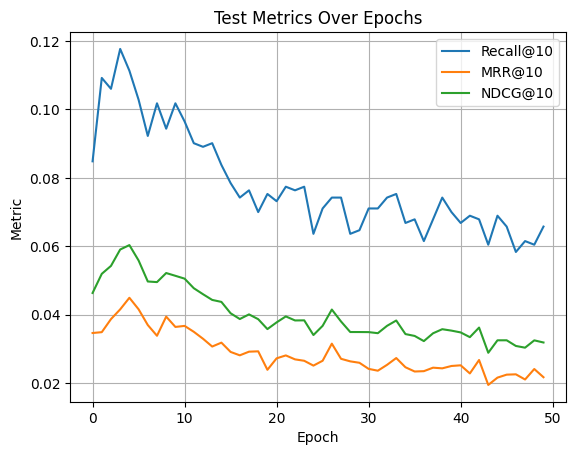


Total run time: 8.98 minutes

User ID: 781
Input sequence:
  - Item 1589: To Have, or Not (1995)
  - Item 1587: Schizopolis (1996)
  - Item 1599: Guantanamera (1994)
  - Item 1334: Tetsuo II: Body Hammer (1992)
  - Item 1347: For Ever Mozart (1996)
  - Item 1536: Cosi (1996)
  - Item 1251: Contempt (Mépris, Le) (1963)
  - Item 1608: Intimate Relations (1996)
  - Item 283: Ulee's Gold (1997)
  - Item 1006: Waiting for Guffman (1996)
  - Item 1588: Salut cousin! (1996)
  - Item 1665: Wedding Bell Blues (1996)
  - Item 1537: All Over Me (1997)
  - Item 284: Promesse, La (1996)
  - Item 1349: Bonheur, Le (1965)
  - Item 40: Shall We Dance? (1996)
  - Item 460: Traveller (1997)
  - Item 1636: Sudden Manhattan (1996)
  - Item 1661: Rough Magic (1995)
  - Item 1666: Next Step, The (1995)
  - Item 927: Brassed Off (1996)
  - Item 1322: Squeeze (1996)
  - Item 1214: Kissed (1996)
  - Item 1240: Van, The (1996)
  - Item 1667: MURDER and murder (1996)
  - Item 1332: Hollow Reed (1996)
  - Item 1

In [ ]:
import os
import zipfile
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import sys
import warnings
import time
warnings.filterwarnings("ignore")

start_time = time.time()

try:
    import wandb
    WANDB_AVAILABLE = True
    # wandb.init(project="xLSTM-MovieLens1M", name="xLSTM-run-50max_len", config={"epochs": 10})


except ImportError:
    WANDB_AVAILABLE = False

sys.path.append("../..")
from xlstm.xlstm_large.model import xLSTMLargeConfig, xLSTMLarge

# -----------------------------
# 1. Download MovieLens 100K
# -----------------------------
DATA_URL = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
DATA_DIR = "ml-100k"

if not os.path.exists(DATA_DIR):
    print("Downloading MovieLens 100K dataset...")
    r = requests.get(DATA_URL)
    with open("ml-100k.zip", "wb") as f:
        f.write(r.content)
    with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Extraction complete.")


# -----------------------------
# 2. Load and split data (with validation)
# -----------------------------
print("\nLoading and splitting data...")
rating_df = pd.read_csv(os.path.join(DATA_DIR, "u.data"), sep="\t", engine='python',
                        names=['user_id', 'movie_id', 'rating', 'timestamp'])

# url_base = "https://files.grouplens.org/datasets/movielens/ml-100k/"
# df = pd.read_csv(url_base + "u.data", sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

# movies = pd.read_csv(url_base + "u.item", sep='|', encoding='latin-1', header=None, engine='python',
#                       names=['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
#                              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
#                              'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
#                              'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

# users = pd.read_csv(url_base + "u.user", sep='|', header=None,
#                      names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
# print("Data loaded in", round((time.time() - start)/60, 2), "minutes")
# print(df.head())

rating_df.sort_values(by=['user_id', 'timestamp'], inplace=True)
user2id = {uid: i for i, uid in enumerate(rating_df['user_id'].unique())}
item2id = {iid: i for i, iid in enumerate(rating_df['movie_id'].unique())}
rating_df['user_id'] = rating_df['user_id'].map(user2id)
rating_df['movie_id'] = rating_df['movie_id'].map(item2id)

num_users = len(user2id)
num_items = len(item2id)

train_seqs, val_seqs, test_seqs = {}, {}, {}
for uid, group in rating_df.groupby('user_id'):
    items = group['movie_id'].tolist()
    if len(items) < 3:
        continue
    train_seqs[uid] = items[:-2]
    val_seqs[uid] = [(items[:i], items[i]) for i in range(1, len(items)-1)]
    test_seqs[uid] = [(items[:-1], items[-1])]


# -----------------------------
# 3. Dataset Classes
# -----------------------------
# class TrainDataset(Dataset):
#     def __init__(self, sequences, max_len=50):
#         self.samples = []
#         for uid, items in sequences.items():
#             for i in range(1, len(items)):
#                 seq = items[max(0, i - max_len):i]
#                 target = items[i]
#                 self.samples.append((seq, target))
#         self.max_len = max_len
#         print(f"Train samples: {len(self.samples)}")

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         seq, target = self.samples[idx]
#         seq = [0] * (self.max_len - len(seq)) + seq
#         return torch.tensor(seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

class TestDataset(Dataset):
    def __init__(self, sequences, max_len=50):
        self.samples = []
        for uid, pairs in sequences.items():
            for seq, tgt in pairs:
                seq = seq[-max_len:]
                self.samples.append((seq, tgt))
        self.max_len = max_len

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq, target = self.samples[idx]
        seq = [0] * (self.max_len - len(seq)) + seq
        return torch.tensor(seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)


class EvalDataset(Dataset):
    def __init__(self, sequences, max_len=50):
        self.samples = []
        for uid, pairs in sequences.items():
            for seq, tgt in pairs:
                seq = seq[-max_len:]
                self.samples.append((uid, seq, tgt))
        self.max_len = max_len

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        uid, seq, tgt = self.samples[idx]
        seq = [0] * (self.max_len - len(seq)) + seq
        return torch.tensor(uid), torch.tensor(seq, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)


train_loader = DataLoader(TrainDataset(train_seqs), batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(EvalDataset(val_seqs), batch_size=256)
test_loader = DataLoader(EvalDataset(test_seqs), batch_size=256)

# -----------------------------
# 4. Model Setup
# -----------------------------
xlstm_config = xLSTMLargeConfig(
    embedding_dim=128,
    num_heads=2,
    num_blocks=2,
    vocab_size=num_items + 1,
    return_last_states=True,
    mode="inference",
    chunkwise_kernel="chunkwise--triton_xl_chunk",
    sequence_kernel="native_sequence__triton",
    step_kernel="triton",
)

if WANDB_AVAILABLE:
    wandb.init(
        project="xLSTM-MovieLens100K",
        name="val-and-lr-scheduler-30epochs",
        notes="1 feature, with val, 2 blocks, 2 heads,100K. Uses validation + LR scheduler. Max_len 50, Embd 128.",

        config={
            "epochs": 30,
            "train_batch_size": 256,
            "val_batch_size": 256,
            "max_len": 50,
            "embedding_dim": 128,
            "num_heads": 2,
            "num_blocks": 2,
            "learning_rate": 0.001,
            "num_users": num_users,
            "num_items": num_items,
            "dataset": "MovieLens-100K",
            "loss_fn": "CrossEntropyLoss"
        }
    )

model = xLSTMLarge(xlstm_config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"\nUsing device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# -----------------------------
# 5. Metrics
# -----------------------------
def recall_mrr_ndcg_k(preds, targets, k=10):
    recall, mrr, ndcg = 0.0, 0.0, 0.0
    for pred, target in zip(preds, targets):
        if target in pred[:k]:
            rank = pred[:k].index(target)
            recall += 1
            mrr += 1.0 / (rank + 1)
            ndcg += 1.0 / np.log2(rank + 2)
    n = len(preds)
    return recall / n, mrr / n, ndcg / n

# -----------------------------
# 6. Training
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
recall_list, mrr_list, ndcg_list = [], [], []

print("\nStarting training...")
for epoch in range(50):
    model.train()
    total_loss = 0
    for seqs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        seqs, targets = seqs.to(device), targets.to(device)
        optimizer.zero_grad()
        logits = model(seqs)[0]
        if logits.dim() == 3:
            logits = logits[:, -1, :]
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Evaluate on test set
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for _, seqs, targets in test_loader:  # <- FIXED LINE
            seqs = seqs.to(device)
            logits = model(seqs)[0]
            if logits.dim() == 3:
                logits = logits[:, -1, :]
            topk = torch.topk(logits, k=10, dim=-1).indices.cpu().tolist()
            all_preds.extend(topk)
            all_targets.extend(targets.tolist())


    recall, mrr, ndcg = recall_mrr_ndcg_k(all_preds, all_targets)
    recall_list.append(recall)
    mrr_list.append(mrr)
    ndcg_list.append(ndcg)

    print(f"Epoch {epoch+1} | Loss: {total_loss:.2f} | Recall@10: {recall:.4f} | MRR@10: {mrr:.4f} | NDCG@10: {ndcg:.4f}")
    if WANDB_AVAILABLE:
        wandb.log({"loss": total_loss, "recall@10": recall, "mrr@10": mrr, "ndcg@10": ndcg})

# -----------------------------
# 7. Plot
# -----------------------------
plt.figure()
plt.plot(recall_list, label='Recall@10')
plt.plot(mrr_list, label='MRR@10')
plt.plot(ndcg_list, label='NDCG@10')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Test Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

elapsed_minutes = (time.time() - start_time) / 60
print(f"\nTotal run time: {elapsed_minutes:.2f} minutes")

# -----------------------------
# 8. Sample Predictions
# -----------------------------
sample_dataset = EvalDataset(test_seqs, max_len=50)
sample_loader = DataLoader(sample_dataset, batch_size=1, shuffle=True)

with torch.no_grad():
    for i, (uid_tensor, seq_tensor, target_tensor) in enumerate(sample_loader):
        uid = uid_tensor.item()
        input_seq = seq_tensor.to(device)
        target = target_tensor.item()

        logits = model(input_seq)[0]
        if logits.dim() == 3:
            logits = logits[:, -1, :]

        probs = torch.softmax(logits, dim=-1)
        topk_logits = torch.topk(logits, k=10, dim=-1)
        topk_probs = torch.topk(probs, k=10, dim=-1)

        topk_items = topk_probs.indices.squeeze().tolist()
        topk_scores = topk_probs.values.squeeze().tolist()
        topk_raw_logits = topk_logits.values.squeeze().tolist()

        input_ids = seq_tensor.squeeze().tolist()
        print(f"\nUser ID: {uid}")
        print("Input sequence:")
        for m in input_ids:
            if m > 0:
                print(f"  - Item {m}: {movie_titles.get(m, 'Unknown')}")

        true_movie = movie_titles.get(target, f"Item {target}")
        true_prob = probs[0, target].item()
        true_logit = logits[0, target].item()
        print(f"True next item: Item {target}: {true_movie} (logit: {true_logit:.4f}, confidence: {true_prob:.4f})")

        print("Top-10 Predictions with scores:")
        for rank, (item, logit_score, prob_score) in enumerate(zip(topk_items, topk_raw_logits, topk_scores), start=1):
            movie_name = movie_titles.get(item, f"Item {item}")
            print(f"  {rank}. Item {item}: {movie_name} (logit: {logit_score:.4f}, confidence: {prob_score:.4f})")

        if i == 4:
            break

# xLSTM 100-k


Loading and splitting data...
Train samples: 97171

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.47 GB


loss,█▆▅▅▄▃▃▂▂▁
mrr@10,▁▂▂▃▄▅▅▆▇█
ndcg@10,▁▂▂▃▄▅▆▆▇█
recall@10,▁▂▃▄▄▅▆▇▇█
test_mrr@10,▁
test_ndcg@10,▁
test_recall@10,▁
loss,1658.30682
mrr@10,0.29791
ndcg@10,0.35514
recall@10,0.54063



Starting training...


Epoch 1: 100%|██████████| 380/380 [00:10<00:00, 36.17it/s]


Epoch 1 | Loss: 2525.68 | Recall@10: 0.1202 | MRR@10: 0.0423 | NDCG@10: 0.0603


Epoch 2: 100%|██████████| 380/380 [00:11<00:00, 34.36it/s]


Epoch 2 | Loss: 2292.04 | Recall@10: 0.1783 | MRR@10: 0.0675 | NDCG@10: 0.0932


Epoch 3: 100%|██████████| 380/380 [00:10<00:00, 37.77it/s]


Epoch 3 | Loss: 2210.17 | Recall@10: 0.2289 | MRR@10: 0.0893 | NDCG@10: 0.1217


Epoch 4: 100%|██████████| 380/380 [00:09<00:00, 38.33it/s]


Epoch 4 | Loss: 2133.37 | Recall@10: 0.2766 | MRR@10: 0.1122 | NDCG@10: 0.1504


Epoch 5: 100%|██████████| 380/380 [00:10<00:00, 37.80it/s]


Epoch 5 | Loss: 2056.40 | Recall@10: 0.3237 | MRR@10: 0.1390 | NDCG@10: 0.1820


Epoch 6: 100%|██████████| 380/380 [00:10<00:00, 37.17it/s]


Epoch 6 | Loss: 1914.05 | Recall@10: 0.3842 | MRR@10: 0.1779 | NDCG@10: 0.2261


Epoch 7: 100%|██████████| 380/380 [00:10<00:00, 37.58it/s]


Epoch 7 | Loss: 1844.27 | Recall@10: 0.4271 | MRR@10: 0.2084 | NDCG@10: 0.2596


Epoch 8: 100%|██████████| 380/380 [00:10<00:00, 37.84it/s]


Epoch 8 | Loss: 1778.81 | Recall@10: 0.4684 | MRR@10: 0.2407 | NDCG@10: 0.2942


Epoch 9: 100%|██████████| 380/380 [00:09<00:00, 38.15it/s]


Epoch 9 | Loss: 1714.61 | Recall@10: 0.5058 | MRR@10: 0.2703 | NDCG@10: 0.3257


Epoch 10: 100%|██████████| 380/380 [00:10<00:00, 37.62it/s]


Epoch 10 | Loss: 1652.82 | Recall@10: 0.5410 | MRR@10: 0.3012 | NDCG@10: 0.3578


Epoch 11: 100%|██████████| 380/380 [00:09<00:00, 38.28it/s]


Epoch 11 | Loss: 1528.99 | Recall@10: 0.5796 | MRR@10: 0.3348 | NDCG@10: 0.3927


Epoch 12: 100%|██████████| 380/380 [00:10<00:00, 37.25it/s]


Epoch 12 | Loss: 1484.92 | Recall@10: 0.5991 | MRR@10: 0.3523 | NDCG@10: 0.4108


Epoch 13: 100%|██████████| 380/380 [00:09<00:00, 38.11it/s]


Epoch 13 | Loss: 1447.64 | Recall@10: 0.6156 | MRR@10: 0.3693 | NDCG@10: 0.4277


Epoch 14: 100%|██████████| 380/380 [00:09<00:00, 38.05it/s]


Epoch 14 | Loss: 1413.32 | Recall@10: 0.6326 | MRR@10: 0.3848 | NDCG@10: 0.4436


Epoch 15: 100%|██████████| 380/380 [00:10<00:00, 37.89it/s]


Epoch 15 | Loss: 1381.02 | Recall@10: 0.6472 | MRR@10: 0.4005 | NDCG@10: 0.4591


Epoch 16: 100%|██████████| 380/380 [00:10<00:00, 36.50it/s]


Epoch 16 | Loss: 1308.99 | Recall@10: 0.6611 | MRR@10: 0.4133 | NDCG@10: 0.4722


Epoch 17: 100%|██████████| 380/380 [00:09<00:00, 38.32it/s]


Epoch 17 | Loss: 1289.20 | Recall@10: 0.6691 | MRR@10: 0.4212 | NDCG@10: 0.4802


Epoch 18: 100%|██████████| 380/380 [00:10<00:00, 37.18it/s]


Epoch 18 | Loss: 1272.27 | Recall@10: 0.6759 | MRR@10: 0.4286 | NDCG@10: 0.4875


Epoch 19: 100%|██████████| 380/380 [00:10<00:00, 37.62it/s]


Epoch 19 | Loss: 1256.12 | Recall@10: 0.6841 | MRR@10: 0.4367 | NDCG@10: 0.4955


Epoch 20: 100%|██████████| 380/380 [00:10<00:00, 37.76it/s]


Epoch 20 | Loss: 1240.61 | Recall@10: 0.6908 | MRR@10: 0.4434 | NDCG@10: 0.5023


Epoch 21: 100%|██████████| 380/380 [00:10<00:00, 37.56it/s]


Epoch 21 | Loss: 1202.33 | Recall@10: 0.6955 | MRR@10: 0.4481 | NDCG@10: 0.5071


Epoch 22: 100%|██████████| 380/380 [00:10<00:00, 36.78it/s]


Epoch 22 | Loss: 1193.79 | Recall@10: 0.6985 | MRR@10: 0.4517 | NDCG@10: 0.5106


Epoch 23: 100%|██████████| 380/380 [00:10<00:00, 37.81it/s]


Epoch 23 | Loss: 1185.85 | Recall@10: 0.7030 | MRR@10: 0.4552 | NDCG@10: 0.5142


Epoch 24: 100%|██████████| 380/380 [00:10<00:00, 37.95it/s]


Epoch 24 | Loss: 1178.14 | Recall@10: 0.7061 | MRR@10: 0.4587 | NDCG@10: 0.5176


Epoch 25: 100%|██████████| 380/380 [00:10<00:00, 37.60it/s]


Epoch 25 | Loss: 1170.45 | Recall@10: 0.7095 | MRR@10: 0.4619 | NDCG@10: 0.5209


Epoch 26: 100%|██████████| 380/380 [00:10<00:00, 38.00it/s]


Epoch 26 | Loss: 1150.65 | Recall@10: 0.7117 | MRR@10: 0.4638 | NDCG@10: 0.5229


Epoch 27: 100%|██████████| 380/380 [00:10<00:00, 37.22it/s]


Epoch 27 | Loss: 1146.68 | Recall@10: 0.7134 | MRR@10: 0.4654 | NDCG@10: 0.5245


Epoch 28: 100%|██████████| 380/380 [00:10<00:00, 37.96it/s]


Epoch 28 | Loss: 1142.81 | Recall@10: 0.7146 | MRR@10: 0.4669 | NDCG@10: 0.5260


Epoch 29: 100%|██████████| 380/380 [00:09<00:00, 38.05it/s]


Epoch 29 | Loss: 1138.94 | Recall@10: 0.7159 | MRR@10: 0.4686 | NDCG@10: 0.5276


Epoch 30: 100%|██████████| 380/380 [00:10<00:00, 37.10it/s]


Epoch 30 | Loss: 1135.28 | Recall@10: 0.7177 | MRR@10: 0.4703 | NDCG@10: 0.5293


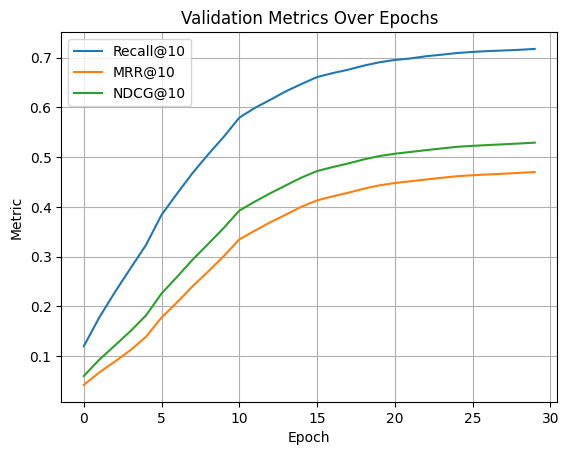


Final test evaluation...
Test Recall@10: 0.0668 | MRR@10: 0.0246 | NDCG@10: 0.0343

Total run time: 8.00 minutes


In [ ]:
import os
import zipfile
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import sys
import warnings
import time
warnings.filterwarnings("ignore")

start_time = time.time()

try:
    import wandb
    WANDB_AVAILABLE = True
except ImportError:
    WANDB_AVAILABLE = False

sys.path.append("../..")
from xlstm.xlstm_large.model import xLSTMLargeConfig, xLSTMLarge

# -----------------------------
# 1. Download MovieLens 100K
# -----------------------------
DATA_URL = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
DATA_DIR = "ml-100k"

if not os.path.exists(DATA_DIR):
    print("Downloading MovieLens 100K dataset...")
    r = requests.get(DATA_URL)
    with open("ml-100k.zip", "wb") as f:
        f.write(r.content)
    with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Extraction complete.")

# -----------------------------
# 2. Load and split data (with validation)
# -----------------------------
print("\nLoading and splitting data...")
rating_df = pd.read_csv(os.path.join(DATA_DIR, "u.data"), sep="\t", engine='python',
                        names=['user_id', 'movie_id', 'rating', 'timestamp'])

rating_df.sort_values(by=['user_id', 'timestamp'], inplace=True)
user2id = {uid: i for i, uid in enumerate(rating_df['user_id'].unique())}
item2id = {iid: i for i, iid in enumerate(rating_df['movie_id'].unique())}
rating_df['user_id'] = rating_df['user_id'].map(user2id)
rating_df['movie_id'] = rating_df['movie_id'].map(item2id)

num_users = len(user2id)
num_items = len(item2id)

train_seqs, val_seqs, test_seqs = {}, {}, {}
for uid, group in rating_df.groupby('user_id'):
    items = group['movie_id'].tolist()
    if len(items) < 3:
        continue
    train_seqs[uid] = items[:-2]
    val_seqs[uid] = [(items[:i], items[i]) for i in range(1, len(items)-1)]
    test_seqs[uid] = [(items[:-1], items[-1])]

# -----------------------------
# 3. Dataset Classes
# -----------------------------
class TrainDataset(Dataset):
    def __init__(self, sequences, max_len=50):
        self.samples = []
        for uid, items in sequences.items():
            for i in range(1, len(items)):
                seq = items[max(0, i - max_len):i]
                target = items[i]
                self.samples.append((seq, target))
        self.max_len = max_len
        print(f"Train samples: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq, target = self.samples[idx]
        seq = [0] * (self.max_len - len(seq)) + seq
        return torch.tensor(seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

class EvalDataset(Dataset):
    def __init__(self, sequences, max_len=50):
        self.samples = []
        for uid, pairs in sequences.items():
            for seq, tgt in pairs:
                seq = seq[-max_len:]
                self.samples.append((uid, seq, tgt))
        self.max_len = max_len

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        uid, seq, tgt = self.samples[idx]
        seq = [0] * (self.max_len - len(seq)) + seq
        return torch.tensor(seq, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)

train_loader = DataLoader(TrainDataset(train_seqs), batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(EvalDataset(val_seqs), batch_size=256)
test_loader = DataLoader(EvalDataset(test_seqs), batch_size=256)

# -----------------------------
# 4. Model Setup
# -----------------------------
xlstm_config = xLSTMLargeConfig(
    embedding_dim=128,
    num_heads=2,
    num_blocks=2,
    vocab_size=num_items + 1,
    return_last_states=True,
    mode="inference",
    chunkwise_kernel="chunkwise--triton_xl_chunk",
    sequence_kernel="native_sequence__triton",
    step_kernel="triton",
)
model = xLSTMLarge(xlstm_config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"\nUsing device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

if WANDB_AVAILABLE:
    wandb.init(
        project="xLSTM-MovieLens100K",
        name="val-and-lr-scheduler-30epochs",
        config={
            "epochs": 30,
            "train_batch_size": 256,
            "val_batch_size": 256,
            "max_len": 50,
            "embedding_dim": 128,
            "num_heads": 2,
            "num_blocks": 2,
            "learning_rate": 0.001,
            "num_users": num_users,
            "num_items": num_items,
            "dataset": "MovieLens-100K",
            "loss_fn": "CrossEntropyLoss"
        }
    )

# -----------------------------
# 5. Metrics
# -----------------------------
def recall_mrr_ndcg_k(preds, targets, k=10):
    recall, mrr, ndcg = 0.0, 0.0, 0.0
    for pred, target in zip(preds, targets):
        if target in pred[:k]:
            rank = pred[:k].index(target)
            recall += 1
            mrr += 1.0 / (rank + 1)
            ndcg += 1.0 / np.log2(rank + 2)
    n = len(preds)
    return recall / n, mrr / n, ndcg / n

# -----------------------------
# 6. Training with Validation and LR Scheduler
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
recall_list, mrr_list, ndcg_list = [], [], []

print("\nStarting training...")
for epoch in range(30):
    model.train()
    total_loss = 0
    for seqs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        seqs, targets = seqs.to(device), targets.to(device)
        optimizer.zero_grad()
        logits = model(seqs)[0]
        if logits.dim() == 3:
            logits = logits[:, -1, :]
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()

    # Evaluate on validation set
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for seqs, targets in val_loader:
            seqs = seqs.to(device)
            logits = model(seqs)[0]
            if logits.dim() == 3:
                logits = logits[:, -1, :]
            topk = torch.topk(logits, k=10, dim=-1).indices.cpu().tolist()
            all_preds.extend(topk)
            all_targets.extend(targets.tolist())

    recall, mrr, ndcg = recall_mrr_ndcg_k(all_preds, all_targets)
    recall_list.append(recall)
    mrr_list.append(mrr)
    ndcg_list.append(ndcg)

    print(f"Epoch {epoch+1} | Loss: {total_loss:.2f} | Recall@10: {recall:.4f} | MRR@10: {mrr:.4f} | NDCG@10: {ndcg:.4f}")
    if WANDB_AVAILABLE:
        wandb.log({"loss": total_loss, "recall@10": recall, "mrr@10": mrr, "ndcg@10": ndcg})

# -----------------------------
# 7. Plot
# -----------------------------
plt.figure()
plt.plot(recall_list, label='Recall@10')
plt.plot(mrr_list, label='MRR@10')
plt.plot(ndcg_list, label='NDCG@10')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Validation Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 8. Final Test Evaluation
# -----------------------------
print("\nFinal test evaluation...")
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for seqs, targets in test_loader:
        seqs = seqs.to(device)
        logits = model(seqs)[0]
        if logits.dim() == 3:
            logits = logits[:, -1, :]
        topk = torch.topk(logits, k=10, dim=-1).indices.cpu().tolist()
        all_preds.extend(topk)
        all_targets.extend(targets.tolist())
recall, mrr, ndcg = recall_mrr_ndcg_k(all_preds, all_targets)
print(f"Test Recall@10: {recall:.4f} | MRR@10: {mrr:.4f} | NDCG@10: {ndcg:.4f}")
if WANDB_AVAILABLE:
    wandb.log({"test_recall@10": recall, "test_mrr@10": mrr, "test_ndcg@10": ndcg})

# -----------------------------
# 9. Total Runtime
# -----------------------------
elapsed_minutes = (time.time() - start_time) / 60
print(f"\nTotal run time: {elapsed_minutes:.2f} minutes")

# xLSTM 1M Datasets

loss,█▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
mrr@10,▁▃▆▅▇█▇▇▆▇▇▄▇▆▅▅▇▅▅▅▅▆▆▅▄▅▅▅▅▄
ndcg@10,▁▃▆▆▇█▇▇▇▇▇▆▇▆▆▆▇▆▆▆▆▇▆▅▅▅▅▅▅▄
recall@10,▁▄▆█▇▇▇█▇▇▇█▇▇▇▆▇▆▆▇▇▇▇▅▅▆▅▅▅▅
loss,21023.12568
mrr@10,0.0782
ndcg@10,0.10231
recall@10,0.18096



Loading and splitting data...
Train samples: 988129

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.47 GB

Starting training...


Epoch 1: 100%|██████████| 3860/3860 [01:56<00:00, 33.19it/s]


Epoch 1 | Loss: 25899.00 | Recall@10: 0.1657 | MRR@10: 0.0722 | NDCG@10: 0.0939


Epoch 2: 100%|██████████| 3860/3860 [01:38<00:00, 39.05it/s]


Epoch 2 | Loss: 24307.41 | Recall@10: 0.1778 | MRR@10: 0.0749 | NDCG@10: 0.0989


Epoch 3: 100%|██████████| 3860/3860 [01:38<00:00, 39.03it/s]


Epoch 3 | Loss: 23837.81 | Recall@10: 0.1811 | MRR@10: 0.0788 | NDCG@10: 0.1028


Epoch 4: 100%|██████████| 3860/3860 [01:38<00:00, 39.00it/s]


Epoch 4 | Loss: 23520.88 | Recall@10: 0.1864 | MRR@10: 0.0813 | NDCG@10: 0.1059


Epoch 5: 100%|██████████| 3860/3860 [01:38<00:00, 39.17it/s]


Epoch 5 | Loss: 23280.03 | Recall@10: 0.1856 | MRR@10: 0.0801 | NDCG@10: 0.1047


Epoch 6: 100%|██████████| 3860/3860 [01:40<00:00, 38.25it/s]


Epoch 6 | Loss: 23084.28 | Recall@10: 0.1869 | MRR@10: 0.0834 | NDCG@10: 0.1076


Epoch 7: 100%|██████████| 3860/3860 [01:38<00:00, 39.01it/s]


Epoch 7 | Loss: 22919.86 | Recall@10: 0.1873 | MRR@10: 0.0825 | NDCG@10: 0.1070


Epoch 8: 100%|██████████| 3860/3860 [01:38<00:00, 39.08it/s]


Epoch 8 | Loss: 22775.01 | Recall@10: 0.1884 | MRR@10: 0.0831 | NDCG@10: 0.1078


Epoch 9: 100%|██████████| 3860/3860 [01:38<00:00, 39.05it/s]


Epoch 9 | Loss: 22643.06 | Recall@10: 0.1868 | MRR@10: 0.0821 | NDCG@10: 0.1065


Epoch 10: 100%|██████████| 3860/3860 [01:39<00:00, 38.96it/s]


Epoch 10 | Loss: 22529.72 | Recall@10: 0.1869 | MRR@10: 0.0810 | NDCG@10: 0.1058


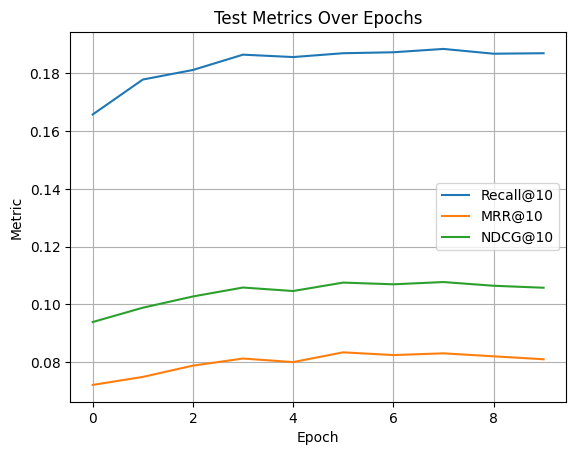


Sample predictions:
Input sequence: [0, 0, 0, 0, 0, 0, 371, 9, 2838, 2044, 81, 388, 62, 524, 791, 225, 861, 1542, 934, 1358, 6, 1654, 451, 474, 230, 1313, 235, 236, 2153, 940, 241, 530, 240, 2824, 523, 244, 242, 1436, 246, 452, 14, 2577, 249, 123, 252, 256, 253, 199, 1635, 395]
True next item: 28
Top-10 Predictions: [1436, 994, 247, 424, 648, 483, 1539, 2895, 2934, 2421]

Input sequence: [770, 2580, 1272, 2489, 1951, 587, 3042, 211, 216, 1493, 985, 1375, 622, 27, 751, 392, 654, 680, 1465, 596, 99, 37, 960, 728, 732, 393, 122, 520, 388, 1524, 391, 81, 299, 407, 414, 795, 310, 733, 899, 1561, 934, 1438, 385, 2029, 1276, 1615, 386, 13, 59, 1933]
True next item: 651
Top-10 Predictions: [628, 1216, 1518, 863, 1935, 1220, 1532, 1137, 1136, 677]

Input sequence: [260, 522, 523, 263, 1586, 1503, 552, 958, 8, 1665, 230, 11, 13, 438, 2631, 63, 2046, 313, 272, 76, 514, 2214, 120, 2012, 1644, 1522, 2059, 524, 1882, 969, 1274, 37, 2234, 971, 217, 133, 306, 432, 132, 148, 134, 1223, 88, 218, 1226, 

In [ ]:
import os
import zipfile
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import sys
import warnings
warnings.filterwarnings("ignore")

try:
    import wandb
    WANDB_AVAILABLE = True
    # wandb.init(project="xLSTM-MovieLens1M", name="xLSTM-run-50max_lenght", config={"epochs": 10})
    wandb.init(
          project="xLSTM-MovieLens1M",
          name="xLSTM-run-without-val-datasets",
          config={
              "epochs": 10,
              "train_batch_size": 256,
              "max_len": 50,
              "embedding_dim": 128,
              "num_heads": 2,
              "num_blocks": 2,
              "learning_rate": 0.001,
              "vocab_size": num_items + 1,
              "dataset": "MovieLens-20M",
              "loss_fn": "CrossEntropyLoss"
          }
      )

except ImportError:
    WANDB_AVAILABLE = False

sys.path.append("../..")
from xlstm.xlstm_large.model import xLSTMLargeConfig, xLSTMLarge

# -----------------------------
# 1. Download MovieLens 1M
# -----------------------------
DATA_URL = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
DATA_DIR = "ml-1m"

if not os.path.exists(DATA_DIR):
    print("Downloading MovieLens 1M dataset...")
    r = requests.get(DATA_URL)
    with open("ml-1m.zip", "wb") as f:
        f.write(r.content)
    with zipfile.ZipFile("ml-1m.zip", 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Extraction complete.")

# -----------------------------
# 2. Load and split for test only
# -----------------------------
print("\nLoading and splitting data...")
rating_df = pd.read_csv(os.path.join(DATA_DIR, "ratings.dat"), sep="::", engine='python',
                        names=['user_id', 'movie_id', 'rating', 'timestamp'])

rating_df.sort_values(by=['user_id', 'timestamp'], inplace=True)
user2id = {uid: i for i, uid in enumerate(rating_df['user_id'].unique())}
item2id = {iid: i for i, iid in enumerate(rating_df['movie_id'].unique())}
rating_df['user_id'] = rating_df['user_id'].map(user2id)
rating_df['movie_id'] = rating_df['movie_id'].map(item2id)

num_users = len(user2id)
num_items = len(item2id)

train_seqs, test_seqs = {}, {}
for uid, group in rating_df.groupby('user_id'):
    items = group['movie_id'].tolist()
    if len(items) < 2:
        continue
    train_seqs[uid] = items[:-1]
    test_seqs[uid] = (items[:-1], items[-1])

# -----------------------------
# 3. Dataset Classes
# -----------------------------
class TrainDataset(Dataset):
    def __init__(self, sequences, max_len=50):
        self.samples = []
        for uid, items in sequences.items():
            for i in range(1, len(items)):
                seq = items[max(0, i - max_len):i]
                target = items[i]
                self.samples.append((seq, target))
        self.max_len = max_len
        print(f"Train samples: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq, target = self.samples[idx]
        seq = [0] * (self.max_len - len(seq)) + seq
        return torch.tensor(seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

class TestDataset(Dataset):
    def __init__(self, sequences, max_len=50):
        self.samples = []
        for uid, (seq, tgt) in sequences.items():
            seq = seq[-max_len:]
            self.samples.append((uid, seq, tgt))
        self.max_len = max_len

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        uid, seq, tgt = self.samples[idx]
        seq = [0] * (self.max_len - len(seq)) + seq
        return torch.tensor(seq, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)

train_loader = DataLoader(TrainDataset(train_seqs), batch_size=256, shuffle=True, num_workers=2)
test_loader = DataLoader(TestDataset(test_seqs), batch_size=256)

# -----------------------------
# 4. Model Setup
# -----------------------------
xlstm_config = xLSTMLargeConfig(
    embedding_dim=128,
    num_heads=2,
    num_blocks=2,
    vocab_size=num_items + 1,
    return_last_states=True,
    mode="inference",
    chunkwise_kernel="chunkwise--triton_xl_chunk",
    sequence_kernel="native_sequence__triton",
    step_kernel="triton",
)
model = xLSTMLarge(xlstm_config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"\nUsing device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# -----------------------------
# 5. Metrics
# -----------------------------
def recall_mrr_ndcg_k(preds, targets, k=10):
    recall, mrr, ndcg = 0.0, 0.0, 0.0
    for pred, target in zip(preds, targets):
        if target in pred[:k]:
            rank = pred[:k].index(target)
            recall += 1
            mrr += 1.0 / (rank + 1)
            ndcg += 1.0 / np.log2(rank + 2)
    n = len(preds)
    return recall / n, mrr / n, ndcg / n

# -----------------------------
# 6. Training
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
recall_list, mrr_list, ndcg_list = [], [], []

print("\nStarting training...")
for epoch in range(10):
    model.train()
    total_loss = 0
    for seqs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        seqs, targets = seqs.to(device), targets.to(device)
        optimizer.zero_grad()
        logits = model(seqs)[0]
        if logits.dim() == 3:
            logits = logits[:, -1, :]
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Evaluate on test set
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for seqs, targets in test_loader:
            seqs = seqs.to(device)
            logits = model(seqs)[0]
            if logits.dim() == 3:
                logits = logits[:, -1, :]
            topk = torch.topk(logits, k=10, dim=-1).indices.cpu().tolist()
            all_preds.extend(topk)
            all_targets.extend(targets.tolist())

    recall, mrr, ndcg = recall_mrr_ndcg_k(all_preds, all_targets)
    recall_list.append(recall)
    mrr_list.append(mrr)
    ndcg_list.append(ndcg)

    print(f"Epoch {epoch+1} | Loss: {total_loss:.2f} | Recall@10: {recall:.4f} | MRR@10: {mrr:.4f} | NDCG@10: {ndcg:.4f}")
    if WANDB_AVAILABLE:
        wandb.log({"loss": total_loss, "recall@10": recall, "mrr@10": mrr, "ndcg@10": ndcg})

# -----------------------------
# 7. Plot
# -----------------------------
plt.figure()
plt.plot(recall_list, label='Recall@10')
plt.plot(mrr_list, label='MRR@10')
plt.plot(ndcg_list, label='NDCG@10')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Test Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 8. Sample Predictions
# -----------------------------
print("\nSample predictions:")
model.eval()
sample_loader = DataLoader(TestDataset(test_seqs), batch_size=1, shuffle=True)
with torch.no_grad():
    for i, (seq, target) in enumerate(sample_loader):
        seq = seq.to(device)
        logits = model(seq)[0]
        if logits.dim() == 3:
            logits = logits[:, -1, :]
        top10 = torch.topk(logits, k=10, dim=-1).indices.cpu().squeeze().tolist()
        print(f"Input sequence: {seq.cpu().squeeze().tolist()}")
        print(f"True next item: {target.item()}")
        print(f"Top-10 Predictions: {top10}\n")
        if i == 4:
            break

In [ ]:
# -----------------------------
# 8. Sample Predictions (with user ID, movie names, item IDs, logits and confidence scores)
# -----------------------------
# Load movie titles
movie_titles = {}
with open(os.path.join(DATA_DIR, "movies.dat"), encoding="latin-1") as f:
    for line in f:
        parts = line.strip().split("::")
        if len(parts) >= 2:
            raw_id, title = parts[0], parts[1]
            if raw_id.isdigit():
                movie_id = item2id.get(int(raw_id))
                if movie_id is not None:
                    movie_titles[movie_id] = title

print("\nSample predictions:")
model.eval()
sample_loader = DataLoader(TestDataset(test_seqs), batch_size=1, shuffle=True)
with torch.no_grad():
    for i, (uid, seq, target) in enumerate([(uid, seq, tgt) for uid, (seq, tgt) in list(test_seqs.items())[:5]]):
        input_seq = [0] * (20 - len(seq)) + seq[-20:]
        input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)
        target_tensor = torch.tensor(target, dtype=torch.long)

        logits = model(input_tensor)[0]
        if logits.dim() == 3:
            logits = logits[:, -1, :]

        probs = torch.softmax(logits, dim=-1)
        topk_logits = torch.topk(logits, k=10, dim=-1)
        topk_probs = torch.topk(probs, k=10, dim=-1)

        topk_items = topk_probs.indices.squeeze().tolist()
        topk_scores = topk_probs.values.squeeze().tolist()
        topk_raw_logits = topk_logits.values.squeeze().tolist()

        print(f"User ID: {uid}")
        print("Input sequence:")
        for m in input_seq:
            if m > 0:
                print(f"  - Item {m}: {movie_titles.get(m, 'Unknown')}")
        true_movie = movie_titles.get(target, f"Item {target}")
        true_prob = probs[0, target].item()
        true_logit = logits[0, target].item()
        print(f"True next item: Item {target}: {true_movie} (logit: {true_logit:.4f}, confidence: {true_prob:.4f})")
        print("Top-10 Predictions with scores:")
        for rank, (item, logit_score, prob_score) in enumerate(zip(topk_items, topk_raw_logits, topk_scores), start=1):
            movie_name = movie_titles.get(item, f"Item {item}")
            print(f"  {rank}. Item {item}: {movie_name} (logit: {logit_score:.4f}, confidence: {prob_score:.4f})")
        print()


Sample predictions:
User ID: 0
Input sequence:
  - Item 32: Secret Garden, The (1993)
  - Item 33: Toy Story 2 (1999)
  - Item 34: Airplane! (1980)
  - Item 35: Pleasantville (1998)
  - Item 36: Dumbo (1941)
  - Item 37: Princess Bride, The (1987)
  - Item 38: Snow White and the Seven Dwarfs (1937)
  - Item 39: Miracle on 34th Street (1947)
  - Item 40: Ponette (1996)
  - Item 41: Schindler's List (1993)
  - Item 42: Beauty and the Beast (1991)
  - Item 43: Tarzan (1999)
  - Item 44: Close Shave, A (1995)
  - Item 45: Aladdin (1992)
  - Item 46: Toy Story (1995)
  - Item 47: Bug's Life, A (1998)
  - Item 48: Antz (1998)
  - Item 49: Hunchback of Notre Dame, The (1996)
  - Item 50: Hercules (1997)
  - Item 51: Mulan (1998)
True next item: Item 52: Pocahontas (1995) (logit: 6.4718, confidence: 0.0217)
Top-10 Predictions with scores:
  1. Item 409: Lion King, The (1994) (logit: 8.6472, confidence: 0.1912)
  2. Item 43: Tarzan (1999) (logit: 7.9581, confidence: 0.0960)
  3. Item 3: Cinder

In [ ]:
#Old without Wandb

Extraction complete.

Loading and processing data...
Initial data sample:
   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291
Total users: 6040, Total items: 3706

Creating dataset...
Total training samples: 994169

Initializing xLSTM model...
Using device: cuda
GPU name: NVIDIA A100-SXM4-40GB
Total GPU memory: 42.47 GB

Starting training...


Epoch 1: 100%|██████████| 3884/3884 [01:38<00:00, 39.44it/s]


Epoch 1 | Loss: 25949.7363 | Recall@10: 0.1840 | MRR@10: 0.0779 | NDCG@10: 0.1026


Epoch 2: 100%|██████████| 3884/3884 [01:19<00:00, 48.91it/s]


Epoch 2 | Loss: 24182.6962 | Recall@10: 0.2088 | MRR@10: 0.0896 | NDCG@10: 0.1174


Epoch 3: 100%|██████████| 3884/3884 [01:19<00:00, 48.93it/s]


Epoch 3 | Loss: 23667.4380 | Recall@10: 0.2224 | MRR@10: 0.0964 | NDCG@10: 0.1258


Epoch 4: 100%|██████████| 3884/3884 [01:20<00:00, 48.09it/s]


Epoch 4 | Loss: 23337.4040 | Recall@10: 0.2334 | MRR@10: 0.1013 | NDCG@10: 0.1321


Epoch 5: 100%|██████████| 3884/3884 [01:18<00:00, 49.27it/s]


Epoch 5 | Loss: 23087.9125 | Recall@10: 0.2418 | MRR@10: 0.1056 | NDCG@10: 0.1374


Epoch 6: 100%|██████████| 3884/3884 [01:19<00:00, 49.06it/s]


Epoch 6 | Loss: 22884.9056 | Recall@10: 0.2494 | MRR@10: 0.1093 | NDCG@10: 0.1420


Epoch 7: 100%|██████████| 3884/3884 [01:19<00:00, 48.89it/s]


Epoch 7 | Loss: 22709.3022 | Recall@10: 0.2556 | MRR@10: 0.1124 | NDCG@10: 0.1458


Epoch 8: 100%|██████████| 3884/3884 [01:20<00:00, 48.46it/s]


Epoch 8 | Loss: 22559.0786 | Recall@10: 0.2622 | MRR@10: 0.1162 | NDCG@10: 0.1503


Epoch 9: 100%|██████████| 3884/3884 [01:19<00:00, 48.79it/s]


Epoch 9 | Loss: 22426.7005 | Recall@10: 0.2670 | MRR@10: 0.1184 | NDCG@10: 0.1531


Epoch 10: 100%|██████████| 3884/3884 [01:19<00:00, 48.95it/s]


Epoch 10 | Loss: 22307.5892 | Recall@10: 0.2721 | MRR@10: 0.1213 | NDCG@10: 0.1565


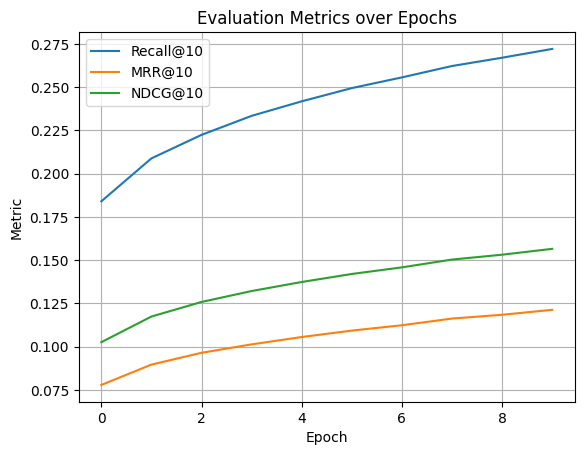


Sample predictions:
Input sequence: [75, 314, 473, 322, 332, 310, 535, 807, 447, 51, 465, 1346, 455, 339, 299, 89, 793, 739, 252, 112]
True next item: 203
Top-10 Predictions: [473, 447, 1249, 339, 114, 2, 600, 343, 1587, 89]

Input sequence: [715, 62, 220, 2326, 222, 441, 928, 778, 873, 524, 866, 224, 904, 2039, 227, 934, 482, 932, 1358, 232]
True next item: 874
Top-10 Predictions: [874, 6, 2060, 231, 1654, 933, 230, 474, 234, 232]

Input sequence: [1191, 578, 542, 1101, 208, 125, 360, 676, 1902, 1346, 115, 370, 2474, 745, 459, 1124, 746, 1250, 337, 464]
True next item: 20
Top-10 Predictions: [542, 125, 368, 1094, 581, 112, 101, 360, 89, 443]

Input sequence: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1402, 41, 1113]
True next item: 491
Top-10 Predictions: [826, 861, 477, 1612, 163, 231, 397, 2843, 169, 62]

Input sequence: [1152, 2374, 2838, 1127, 1433, 1292, 2383, 1128, 2389, 270, 614, 940, 1082, 2666, 800, 1256, 1826, 2512, 1752, 2217]
True next item: 729
Top-10 Prediction

In [ ]:
import os
import zipfile
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import sys

# pip install mlstm_kernels
# pip install xlstm

sys.path.append("../..")
from xlstm.xlstm_large.model import xLSTMLargeConfig, xLSTMLarge

# -----------------------------
# 1. Download and extract MovieLens 1M dataset
# -----------------------------
DATA_URL = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
DATA_DIR = "ml-1m"

if not os.path.exists(DATA_DIR):
    print("Downloading MovieLens 1M dataset...")
    r = requests.get(DATA_URL)
    with open("ml-1m.zip", "wb") as f:
        f.write(r.content)
    with zipfile.ZipFile("ml-1m.zip", 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Extraction complete.")

# -----------------------------
# 2. Load and process data
# -----------------------------
print("\nLoading and processing data...")
rating_df = pd.read_csv(os.path.join(DATA_DIR, "ratings.dat"), sep="::", engine='python',
                        names=['user_id', 'movie_id', 'rating', 'timestamp'])
print("Initial data sample:")
print(rating_df.head())

rating_df.sort_values(by=['user_id', 'timestamp'], inplace=True)
user2id = {uid: i for i, uid in enumerate(rating_df['user_id'].unique())}
item2id = {iid: i for i, iid in enumerate(rating_df['movie_id'].unique())}
rating_df['user_id'] = rating_df['user_id'].map(user2id)
rating_df['movie_id'] = rating_df['movie_id'].map(item2id)

num_users = len(user2id)
num_items = len(item2id)
print(f"Total users: {num_users}, Total items: {num_items}")

user_seqs = rating_df.groupby('user_id')['movie_id'].apply(list).to_dict()

# -----------------------------
# 3. Dataset and DataLoader
# -----------------------------
class MovieLensDataset(Dataset):
    def __init__(self, user_sequences, max_len=50):
        self.samples = []
        self.max_len = max_len
        for user, items in user_sequences.items():
            for i in range(1, len(items)):
                seq = items[max(0, i - max_len):i]
                target = items[i]
                self.samples.append((seq, target))
        print(f"Total training samples: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq, target = self.samples[idx]
        seq = [0] * (self.max_len - len(seq)) + seq
        return torch.tensor(seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

print("\nCreating dataset...")
train_dataset = MovieLensDataset(user_seqs, max_len=50)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)

# -----------------------------
# 4. xLSTM Model Setup
# -----------------------------
print("\nInitializing xLSTM model...")
xlstm_config = xLSTMLargeConfig(
    embedding_dim=128,
    num_heads=2,
    num_blocks=2,
    vocab_size=num_items + 1,
    return_last_states=True,
    mode="inference",
    chunkwise_kernel="chunkwise--triton_xl_chunk",
    sequence_kernel="native_sequence__triton",
    step_kernel="triton",
)
model = xLSTMLarge(xlstm_config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# -----------------------------
# 5. Evaluation Metrics
# -----------------------------
def recall_mrr_ndcg_k(preds, targets, k=10):
    recall, mrr, ndcg = 0.0, 0.0, 0.0
    for pred, target in zip(preds, targets):
        if target in pred[:k]:
            recall += 1
            rank = pred[:k].index(target)
            mrr += 1.0 / (rank + 1)
            ndcg += 1.0 / np.log2(rank + 2)
    n = len(preds)
    return recall / n, mrr / n, ndcg / n

# -----------------------------
# 6. Training Loop
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
recall_list, mrr_list, ndcg_list = [], [], []

print("\nStarting training...")
for epoch in range(10):
    model.train()
    total_loss = 0
    for seqs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        seqs, targets = seqs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(seqs)
        logits = outputs[0] if isinstance(outputs, tuple) else outputs
        if logits.dim() == 3:
            logits = logits[:, -1, :]
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Evaluation
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for seqs, targets in train_loader:
            seqs = seqs.to(device)
            outputs = model(seqs)
            logits = outputs[0] if isinstance(outputs, tuple) else outputs
            if logits.dim() == 3:
                logits = logits[:, -1, :]
            topk = torch.topk(logits, k=10, dim=-1).indices.cpu().tolist()
            all_preds.extend(topk)
            all_targets.extend(targets.tolist())

    recall, mrr, ndcg = recall_mrr_ndcg_k(all_preds, all_targets)
    recall_list.append(recall)
    mrr_list.append(mrr)
    ndcg_list.append(ndcg)
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Recall@10: {recall:.4f} | MRR@10: {mrr:.4f} | NDCG@10: {ndcg:.4f}")

# -----------------------------
# 7. Plotting results
# -----------------------------
plt.figure()
plt.plot(recall_list, label='Recall@10')
plt.plot(mrr_list, label='MRR@10')
plt.plot(ndcg_list, label='NDCG@10')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Evaluation Metrics over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 8. Sample Predictions
# -----------------------------
print("\nSample predictions:")
model.eval()
sample_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
with torch.no_grad():
    for i, (seq, target) in enumerate(sample_loader):
        seq = seq.to(device)
        outputs = model(seq)
        logits = outputs[0] if isinstance(outputs, tuple) else outputs
        if logits.dim() == 3:
            logits = logits[:, -1, :]
        top10 = torch.topk(logits, k=10, dim=-1).indices.cpu().squeeze().tolist()
        print(f"Input sequence: {seq.cpu().squeeze().tolist()}")
        print(f"True next item: {target.item()}")
        print(f"Top-10 Predictions: {top10}\n")
        if i == 4:
            break

# LSTM 1M

Loading data...
Sample ratings:
   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291
Number of users: 6040, Number of items: 3706

Starting training...


100%|██████████| 7767/7767 [00:37<00:00, 206.48it/s]


Epoch 1 | Loss: 49597.2906 | Recall@10: 0.1966 | MRR@10: 0.0748 | NDCG@10: 0.1030


100%|██████████| 7767/7767 [00:36<00:00, 211.06it/s]


Epoch 2 | Loss: 44632.0847 | Recall@10: 0.2272 | MRR@10: 0.0905 | NDCG@10: 0.1222


100%|██████████| 7767/7767 [00:37<00:00, 208.75it/s]


Epoch 3 | Loss: 43452.0213 | Recall@10: 0.2441 | MRR@10: 0.1000 | NDCG@10: 0.1335


100%|██████████| 7767/7767 [00:36<00:00, 210.86it/s]


Epoch 4 | Loss: 42795.8851 | Recall@10: 0.2565 | MRR@10: 0.1067 | NDCG@10: 0.1415


100%|██████████| 7767/7767 [00:36<00:00, 212.05it/s]


Epoch 5 | Loss: 42345.9082 | Recall@10: 0.2662 | MRR@10: 0.1119 | NDCG@10: 0.1478


100%|██████████| 7767/7767 [00:36<00:00, 210.29it/s]


Epoch 6 | Loss: 42009.8025 | Recall@10: 0.2731 | MRR@10: 0.1154 | NDCG@10: 0.1521


100%|██████████| 7767/7767 [00:36<00:00, 211.03it/s]


Epoch 7 | Loss: 41742.6509 | Recall@10: 0.2801 | MRR@10: 0.1192 | NDCG@10: 0.1567


100%|██████████| 7767/7767 [00:37<00:00, 209.85it/s]


Epoch 8 | Loss: 41519.3403 | Recall@10: 0.2848 | MRR@10: 0.1216 | NDCG@10: 0.1596


100%|██████████| 7767/7767 [00:36<00:00, 210.37it/s]


Epoch 9 | Loss: 41331.8780 | Recall@10: 0.2898 | MRR@10: 0.1244 | NDCG@10: 0.1629


100%|██████████| 7767/7767 [00:36<00:00, 210.66it/s]


Epoch 10 | Loss: 41170.6377 | Recall@10: 0.2932 | MRR@10: 0.1266 | NDCG@10: 0.1655


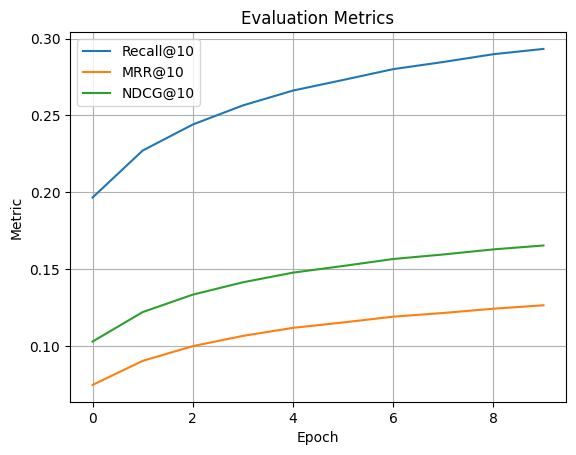


Sample predictions:
Input sequence: [215, 1758, 452, 2814, 902, 762, 1459, 1633, 1136, 540, 996, 1280, 1281, 208, 341, 146, 871, 141, 913, 893, 747, 2110, 489, 876, 1846, 2133, 875, 1913, 2648, 1918, 1054, 210, 576, 1480, 2252, 156, 1401, 157, 397, 756, 153, 161, 2703, 325, 2007, 1635, 186, 828, 438, 6]
True next item: 2273
Top-10 Predictions: [436, 2012, 2065, 95, 2042, 14, 521, 828, 1959, 2718]

Input sequence: [88, 217, 183, 111, 214, 594, 208, 1254, 1028, 432, 632, 132, 1026, 439, 189, 143, 148, 185, 1029, 1027, 136, 840, 754, 163, 191, 1003, 843, 12, 751, 87, 181, 258, 609, 101, 742, 134, 141, 192, 190, 44, 33, 519, 196, 62, 520, 199, 127, 2003, 1, 267]
True next item: 891
Top-10 Predictions: [13, 270, 273, 271, 267, 60, 564, 552, 78, 130]

Input sequence: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 774, 218, 662]
True next item: 65
Top-10 Predictions: [9, 54, 16, 15, 53, 41, 430, 55

In [ ]:
import os
import zipfile
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# -----------------------------
# 1. Download and extract MovieLens 1M dataset
# -----------------------------

DATA_URL = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
DATA_DIR = "ml-1m"

if not os.path.exists(DATA_DIR):
    print("Downloading MovieLens 1M dataset...")
    r = requests.get(DATA_URL)
    with open("ml-1m.zip", "wb") as f:
        f.write(r.content)
    with zipfile.ZipFile("ml-1m.zip", 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Extraction complete.")

# -----------------------------
# 2. Load and process data
# -----------------------------

print("Loading data...")
rating_df = pd.read_csv(os.path.join(DATA_DIR, "ratings.dat"), sep="::", engine='python',
                        names=['user_id', 'movie_id', 'rating', 'timestamp'])
print("Sample ratings:")
print(rating_df.head())

# Sort by timestamp for each user
rating_df.sort_values(by=['user_id', 'timestamp'], inplace=True)

# Map to contiguous IDs
user2id = {uid: i for i, uid in enumerate(rating_df['user_id'].unique())}
item2id = {iid: i for i, iid in enumerate(rating_df['movie_id'].unique())}
rating_df['user_id'] = rating_df['user_id'].map(user2id)
rating_df['movie_id'] = rating_df['movie_id'].map(item2id)

num_users = len(user2id)
num_items = len(item2id)

print(f"Number of users: {num_users}, Number of items: {num_items}")

# Group by user
user_seqs = rating_df.groupby('user_id')['movie_id'].apply(list).to_dict()

# -----------------------------
# 3. Dataset and DataLoader
# -----------------------------

class MovieLensDataset(Dataset):
    def __init__(self, user_sequences, max_len=50):
        self.samples = []
        self.max_len = max_len
        for user, items in user_sequences.items():
            for i in range(1, len(items)):
                seq = items[max(0, i - max_len):i]
                target = items[i]
                self.samples.append((seq, target))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq, target = self.samples[idx]
        seq = [0] * (self.max_len - len(seq)) + seq
        return torch.tensor(seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

train_dataset = MovieLensDataset(user_seqs)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# -----------------------------
# 4. xLSTM Model (simple version)
# -----------------------------

class xLSTM(nn.Module):
    def __init__(self, num_items, emb_dim=64, hidden_dim=64):
        super(xLSTM, self).__init__()
        self.embedding = nn.Embedding(num_items + 1, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True)
        self.output = nn.Linear(hidden_dim, num_items)

    def forward(self, x):
        emb = self.embedding(x)
        output, _ = self.lstm(emb)
        final_hidden = output[:, -1, :]
        logits = self.output(final_hidden)
        return logits

# -----------------------------
# 5. Evaluation Metrics
# -----------------------------

def recall_mrr_ndcg_k(preds, targets, k=10):
    recall, mrr, ndcg = 0.0, 0.0, 0.0
    for pred, target in zip(preds, targets):
        if target in pred[:k]:
            recall += 1
            rank = pred[:k].index(target)
            mrr += 1.0 / (rank + 1)
            ndcg += 1.0 / np.log2(rank + 2)
    n = len(preds)
    return recall / n, mrr / n, ndcg / n

# -----------------------------
# 6. Training Loop
# -----------------------------

model = xLSTM(num_items)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

recall_list, mrr_list, ndcg_list = [], [], []

print("\nStarting training...")
for epoch in range(10):
    model.train()
    total_loss = 0
    for seqs, targets in tqdm(train_loader):
        seqs, targets = seqs.to(device), targets.to(device)
        optimizer.zero_grad()
        logits = model(seqs)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for seqs, targets in train_loader:
            seqs = seqs.to(device)
            logits = model(seqs)
            topk = torch.topk(logits, k=10, dim=-1).indices.cpu().tolist()
            all_preds.extend(topk)
            all_targets.extend(targets.tolist())

    recall, mrr, ndcg = recall_mrr_ndcg_k(all_preds, all_targets)
    recall_list.append(recall)
    mrr_list.append(mrr)
    ndcg_list.append(ndcg)
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Recall@10: {recall:.4f} | MRR@10: {mrr:.4f} | NDCG@10: {ndcg:.4f}")

# -----------------------------
# 7. Plotting results
# -----------------------------

plt.figure()
plt.plot(recall_list, label='Recall@10')
plt.plot(mrr_list, label='MRR@10')
plt.plot(ndcg_list, label='NDCG@10')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Evaluation Metrics')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 8. Sample Predictions
# -----------------------------

print("\nSample predictions:")
model.eval()
sample_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
with torch.no_grad():
    for i, (seq, target) in enumerate(sample_loader):
        seq = seq.to(device)
        logits = model(seq)
        top10 = torch.topk(logits, k=10, dim=-1).indices.cpu().squeeze().tolist()
        print(f"Input sequence: {seq.cpu().squeeze().tolist()}")
        print(f"True next item: {target.item()}")
        print(f"Top-10 Predictions: {top10}\n")
        if i == 4:
            break


In [ ]:
# 1. Importing Packages

import os
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# --- GPU Setup and Debug ---
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # Show all TF logs
# tf.debugging.set_log_device_placement(True)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU(s) detected and memory growth enabled:", gpus)
    except RuntimeError as e:
        print("⚠️ RuntimeError while enabling memory growth:", e)
else:
    print("❌ No GPU detected. Training will run on CPU.")


✅ GPU(s) detected and memory growth enabled: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# 2. Loading Data
start = time.time()
url_base = "https://files.grouplens.org/datasets/movielens/ml-100k/"
df = pd.read_csv(url_base + "u.data", sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

movies = pd.read_csv(url_base + "u.item", sep='|', encoding='latin-1', header=None, engine='python',
                      names=['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
                             'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                             'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                             'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

users = pd.read_csv(url_base + "u.user", sep='|', header=None,
                     names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
print("Data loaded in", round((time.time() - start)/60, 2), "minutes")
print(df.head())


Data loaded in 0.09 minutes
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


In [ ]:
# 3. Preprocess Data
start = time.time()
df['item_id'] = df['item_id'].astype(str)
movies['item_id'] = movies['item_id'].astype(str)
df = df.merge(users, on='user_id', how='left')
df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s').astype(int) // 10**9
df = df.merge(movies, on='item_id', how='left')
df.drop(columns=['IMDb_URL', 'video_release_date', 'unknown'], inplace=True)
df = df.sort_values(by=['user_id', 'timestamp'])
print("Preprocessing done in", round((time.time() - start)/60, 2), "minutes")
print(df.head())

Preprocessing done in 0.0 minutes
       user_id item_id  rating  timestamp  age gender  occupation zip_code  \
59972        1     168       5  874965478   24      M  technician    85711   
92487        1     172       5  874965478   24      M  technician    85711   
74577        1     165       5  874965518   24      M  technician    85711   
48214        1     156       4  874965556   24      M  technician    85711   
15764        1     196       5  874965677   24      M  technician    85711   

                                        title release_date  ...  Fantasy  \
59972  Monty Python and the Holy Grail (1974)  01-Jan-1974  ...        0   
92487         Empire Strikes Back, The (1980)  01-Jan-1980  ...        0   
74577                 Jean de Florette (1986)  01-Jan-1986  ...        0   
48214                   Reservoir Dogs (1992)  01-Jan-1992  ...        0   
15764               Dead Poets Society (1989)  01-Jan-1989  ...        0   

       Film-Noir  Horror  Musical  Myste

In [ ]:
# 4. Create item mappings and train-test split
start = time.time()
unique_items = df['item_id'].unique()
item_to_idx = {item: idx + 1 for idx, item in enumerate(unique_items)}
idx_to_item = {idx: item for item, idx in item_to_idx.items()}
idx_to_title = {item_to_idx[row['item_id']]: row['title'] for _, row in movies.iterrows() if row['item_id'] in item_to_idx}
print("Mappings created in", round((time.time() - start)/60, 2), "minutes")
print(list(item_to_idx.items())[:5])

# Train-test split per user
start = time.time()
def user_based_split(data, test_ratio=0.2):
    train_rows, test_rows = [], []
    for _, group in data.groupby('user_id'):
        n_test = int(len(group) * test_ratio)
        group_sorted = group.sort_values(by='timestamp')
        if n_test > 0:
            test_rows.append(group_sorted.tail(n_test))
            train_rows.append(group_sorted.head(len(group) - n_test))
        else:
            train_rows.append(group_sorted)
    train_df = pd.concat(train_rows)
    test_df = pd.concat(test_rows)
    return train_df, test_df

train_df, test_df = user_based_split(df, test_ratio=0.2)
print("Train-test split done in", round((time.time() - start)/60, 2), "minutes")
print(train_df.head())
print(test_df.head())

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")
print(f"Number of users in train set: {train_df['user_id'].nunique()}, Number of users in test set: {test_df['user_id'].nunique()}")
print(f"Number of items in train set: {train_df['item_id'].nunique()}, Number of items in test set: {test_df['item_id'].nunique()}")

Mappings created in 0.0 minutes
[('168', 1), ('172', 2), ('165', 3), ('156', 4), ('196', 5)]
Train-test split done in 0.01 minutes
       user_id item_id  rating  timestamp  age gender  occupation zip_code  \
59972        1     168       5  874965478   24      M  technician    85711   
92487        1     172       5  874965478   24      M  technician    85711   
74577        1     165       5  874965518   24      M  technician    85711   
48214        1     156       4  874965556   24      M  technician    85711   
15764        1     196       5  874965677   24      M  technician    85711   

                                        title release_date  ...  Fantasy  \
59972  Monty Python and the Holy Grail (1974)  01-Jan-1974  ...        0   
92487         Empire Strikes Back, The (1980)  01-Jan-1980  ...        0   
74577                 Jean de Florette (1986)  01-Jan-1986  ...        0   
48214                   Reservoir Dogs (1992)  01-Jan-1992  ...        0   
15764               

In [ ]:
# 5. Sequence Tokenization & Creation (Extended with User and Genre Info)
start = time.time()

# Prepare genre vector lookup
genre_columns = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
                 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
genre_lookup = movies.set_index('item_id')[genre_columns].astype('float32').to_dict('index')

# Prepare user feature lookup
user_feature_lookup = users.set_index('user_id')[['age', 'gender', 'occupation']].copy()
user_feature_lookup['gender'] = user_feature_lookup['gender'].map({'M': 0, 'F': 1})
user_feature_lookup['occupation'] = user_feature_lookup['occupation'].astype('category').cat.codes
user_feature_lookup = user_feature_lookup.astype('float32').to_dict('index')

# Tokenize item_id sequences
print("Tokenizing item_id sequences...")
def tokenize_data(data):
    return data.groupby('user_id')['item_id'].apply(lambda x: [item_to_idx.get(i, 0) for i in x]).reset_index()

train_sequences = tokenize_data(train_df)
test_sequences = tokenize_data(test_df)

print("Tokenization complete in", round((time.time() - start)/60, 2), "minutes")
print("\nTrain Sequence Stats:")
train_lens = train_sequences['item_id'].apply(len)
print(f"Number of users with sequences: {len(train_sequences)}")
print(f"Average sequence length per user: {train_lens.mean():.2f}")
print(f"Max sequence length in any user: {train_lens.max()}")

print("\nTest Sequence Stats:")
test_lens = test_sequences['item_id'].apply(len)
print(f"Number of users with sequences: {len(test_sequences)}")
print(f"Average sequence length per user: {test_lens.mean():.2f}")
print(f"Max sequence length in any user: {test_lens.max()}")

start = time.time()
max_seq_len = 150

def create_sequences(sequences, dataset_type):
    input_seqs, labels, user_feats, genre_seqs = [], [], [], []
    drop_count = 0

    for _, row in sequences.iterrows():
        user_id = row['user_id']
        seq = row['item_id']
        if len(seq) < 2:
            drop_count += 1
            continue

        ufeat = user_feature_lookup.get(user_id, {'age': 0, 'gender': 0, 'occupation': 0})
        ufeat_vec = [ufeat['age'], ufeat['gender'], ufeat['occupation']]

        for i in range(1, len(seq)):
            input_seq = seq[max(0, i - max_seq_len):i]
            label = seq[i]
            input_seq = [0] * (max_seq_len - len(input_seq)) + input_seq
            genre_seq = [genre_lookup.get(idx_to_item.get(i, '0'), dict.fromkeys(genre_columns, 0.0)) for i in input_seq]
            genre_seq = [[g[k] for k in genre_columns] for g in genre_seq]

            input_seqs.append(input_seq)
            labels.append(label)
            user_feats.append(ufeat_vec)
            genre_seqs.append(genre_seq)

    print(f"Total {dataset_type} sequences created: {len(input_seqs)}")
    print(f"Dropped {drop_count} user sequences due to insufficient length.")
    return (np.array(input_seqs, dtype=np.int32),
            np.array(labels, dtype=np.int32),
            np.array(user_feats, dtype=np.float32),
            np.array(genre_seqs, dtype=np.float32))

train_input, train_labels, train_user_feats, train_genres = create_sequences(train_sequences, 'train')
test_input, test_labels, test_user_feats, test_genres = create_sequences(test_sequences, 'test')

print("Sequence creation done in", round((time.time() - start)/60, 2), "minutes")
print(f"Train input shape: {train_input.shape}, Labels shape: {train_labels.shape}")
print(f"Test input shape: {test_input.shape}, Labels shape: {test_labels.shape}")

print("\nSample padded input sequences:")
for i in range(3):
    print(f"Input: {train_input[i][-10:]} ➞ Label: {train_labels[i]} (Movie: {idx_to_title.get(train_labels[i], 'UNK')})")

print("\nSample enriched sequences (Input IDs, Genres, User Features):")
for i in range(3):
    print(f"\n--- Sequence #{i+1} ---")
    print(f"Input IDs:  {train_input[i][-10:]}")
    print(f"Genre vec (last token): {train_genres[i][-1]}")
    print(f"User features: {train_user_feats[i]}")
    print(f"Label: {train_labels[i]} | Title: {idx_to_title.get(train_labels[i], 'UNK')}")

# Print full enriched view for first 3 users
print("\n\nDetailed tokenized view for first 3 users:")
for i in range(3):
    print(f"\n===== User {train_sequences.iloc[i]['user_id']} =====")
    full_seq = train_sequences.iloc[i]['item_id']
    for j in range(min(len(full_seq)-1, 40)):
        token_id = full_seq[j]
        genre_vec = genre_lookup.get(idx_to_item.get(token_id, '0'), dict.fromkeys(genre_columns, 0.0))
        user_feat = user_feature_lookup.get(train_sequences.iloc[i]['user_id'], {})
        print(f"Token {j+1}: ID={token_id}, Genres={[genre_vec[k] for k in genre_columns]}, User Feats={[user_feat.get('age',0), user_feat.get('gender',0), user_feat.get('occupation',0)]}")

num_users = df['user_id'].nunique()
num_items = df['item_id'].nunique()
num_interactions = len(df)
sparsity = 1 - (num_interactions / (num_users * num_items))
print("\nDataset Statistics:")
print("Dataset    Users    Items    Interactions    Avg. len.    Sparsity")
print(f"ML-100K    {num_users:<9} {num_items:<8} {num_interactions:<15} {train_lens.mean() + test_lens.mean():<13.2f} {sparsity:.4f}")

Tokenizing item_id sequences...
Tokenization complete in 0.0 minutes

Train Sequence Stats:
Number of users with sequences: 943
Average sequence length per user: 85.22
Max sequence length in any user: 590

Test Sequence Stats:
Number of users with sequences: 943
Average sequence length per user: 20.82
Max sequence length in any user: 147
Total train sequences created: 79424
Dropped 0 user sequences due to insufficient length.
Total test sequences created: 18690
Dropped 0 user sequences due to insufficient length.
Sequence creation done in 0.96 minutes
Train input shape: (79424, 150), Labels shape: (79424,)
Test input shape: (18690, 150), Labels shape: (18690,)

Sample padded input sequences:
Input: [0 0 0 0 0 0 0 0 0 1] ➞ Label: 2 (Movie: Empire Strikes Back, The (1980))
Input: [0 0 0 0 0 0 0 0 1 2] ➞ Label: 3 (Movie: Jean de Florette (1986))
Input: [0 0 0 0 0 0 0 1 2 3] ➞ Label: 4 (Movie: Reservoir Dogs (1992))

Sample enriched sequences (Input IDs, Genres, User Features):

--- Sequen

In [ ]:
# 6. Enhanced xLSTM Model to Integrate Genres and User Features
class xLSTM(tf.keras.Model):
    def __init__(self, vocab_size, hidden_units=256, num_layers=4, dropout_rate=0.2, max_len=150, genre_dim=18, user_dim=3):
        super(xLSTM, self).__init__()
        self.max_len = max_len
        self.hidden_units = hidden_units

        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=hidden_units)
        self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_len, output_dim=hidden_units)

        self.genre_proj = tf.keras.layers.Dense(hidden_units)
        self.user_proj = tf.keras.layers.Dense(hidden_units)
        self.concat_proj = tf.keras.layers.Dense(hidden_units)  # project concatenated input back

        self.mlstm_layers = []
        for _ in range(num_layers // 2):
            conv = tf.keras.layers.Conv1D(filters=hidden_units, kernel_size=3, padding='same')
            attn = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=hidden_units // 4)
            norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
            self.mlstm_layers.append((conv, attn, norm))

        self.slstm_layers = []
        for idx in range(num_layers // 2):
            lstm = tf.keras.layers.LSTM(hidden_units, return_sequences=(idx < num_layers // 2 - 1), dropout=dropout_rate)
            norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
            self.slstm_layers.append((lstm, norm))

        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.output_dense = tf.keras.layers.Dense(vocab_size)

    def call(self, input_ids, genre_seq, user_feats, training=False):
        batch_size = tf.shape(input_ids)[0]
        positions = tf.range(start=0, limit=self.max_len, delta=1)
        positions = tf.broadcast_to(positions, shape=(batch_size, self.max_len))

        print(f"[DEBUG] input_ids shape: {input_ids.shape}")
        print(f"[DEBUG] genre_seq shape: {genre_seq.shape}")
        print(f"[DEBUG] user_feats shape: {user_feats.shape}")
        print(f"[DEBUG] positions shape: {positions.shape}")

        token_embed = self.embedding(input_ids)
        pos_embed = self.pos_embedding(positions)
        genre_embed = self.genre_proj(genre_seq)

        print(f"[DEBUG] token_embed shape: {token_embed.shape}")
        print(f"[DEBUG] pos_embed shape: {pos_embed.shape}")
        print(f"[DEBUG] genre_embed shape: {genre_embed.shape}")

        user_embed = self.user_proj(user_feats)
        user_embed = tf.expand_dims(user_embed, 1)
        user_embed = tf.repeat(user_embed, repeats=self.max_len, axis=1)

        print(f"[DEBUG] user_embed shape after repeat: {user_embed.shape}")

        x = tf.concat([token_embed, pos_embed, genre_embed, user_embed], axis=-1)
        x = self.concat_proj(x)

        print(f"[DEBUG] Combined input (x) shape after concat+proj: {x.shape}")

        for i, (conv, attn, norm) in enumerate(self.mlstm_layers):
            conv_out = conv(x)
            attn_out = attn(conv_out, conv_out)
            x = norm(x + attn_out)
            x = self.dropout(x, training=training)
            print(f"[DEBUG] After MLSTM layer {i+1}: {x.shape}")

        for i, (lstm, norm) in enumerate(self.slstm_layers):
            x = lstm(x, training=training)
            x = norm(x)
            print(f"[DEBUG] After SLSTM layer {i+1}: {x.shape}")

        out = self.output_dense(x)
        print(f"[DEBUG] Final output shape: {out.shape}")
        return out

In [ ]:
# Section 7: Training Loop and Evaluation with Feature Integration
import numpy as np
import time
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected! Please set runtime to GPU.")

# Prepare dataset tuples
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_genres, train_user_feats, train_labels)) \
    .shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_genres, test_user_feats, test_labels)) \
    .batch(batch_size).prefetch(tf.data.AUTOTUNE)

metrics_history = {
    "recall@10": [], "mrr@10": [], "ndcg@10": [], "hit@10": [], "precision@10": []
}

def evaluate_model(model, test_dataset, top_k=10):
    recall, mrr, ndcg, hit, precision = 0, 0, 0, 0, 0
    total_preds = 0

    for batch_inputs, batch_genres, batch_user_feats, batch_labels in test_dataset:
        logits = model(batch_inputs, batch_genres, batch_user_feats, training=False)
        if logits.ndim == 3:
            logits = logits[:, -1, :]
        top_k_preds = tf.math.top_k(logits, k=top_k).indices.numpy()
        targets = batch_labels.numpy()

        for pred, label in zip(top_k_preds, targets):
            total_preds += 1
            if label in pred:
                hit += 1
                recall += 1
                precision += 1 / top_k
                rank = np.where(pred == label)[0][0]
                mrr += 1 / (rank + 1)
                dcg = 1 / np.log2(rank + 2)
            else:
                dcg = 0
            idcg = 1 / np.log2(2)
            ndcg += dcg / idcg

    if total_preds == 0:
        total_preds = 1
    metrics_history["recall@10"].append(recall / total_preds)
    metrics_history["mrr@10"].append(mrr / total_preds)
    metrics_history["ndcg@10"].append(ndcg / total_preds)
    metrics_history["hit@10"].append(hit / total_preds)
    metrics_history["precision@10"].append(precision / total_preds)

# --- Training Loop ---
with tf.device('/GPU:0'):
    model = xLSTM(vocab_size=len(item_to_idx) + 1, max_len=max_seq_len)
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    @tf.function
    def train_step(batch_inputs, batch_genres, batch_user_feats, batch_labels):
        with tf.GradientTape() as tape:
            logits = model(batch_inputs, batch_genres, batch_user_feats, training=True)
            if logits.ndim == 3:
                logits = logits[:, -1, :]
            loss = loss_fn(batch_labels, logits)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss

    start = time.time()
    for epoch in range(30):
        print(f"\nEpoch {epoch+1}/30")
        epoch_loss = 0
        for batch_inputs, batch_genres, batch_user_feats, batch_labels in train_dataset:
            loss = train_step(batch_inputs, batch_genres, batch_user_feats, batch_labels)
            epoch_loss += loss.numpy()

        print(f"Training Loss: {epoch_loss:.4f}")
        print(f"Feeding {batch_inputs.shape[-1]} token IDs, {batch_genres.shape[-1]} genre dims, and {batch_user_feats.shape[-1]} user dims into the model.")

        evaluate_model(model, test_dataset, top_k=10)
        print(f"Evaluation at epoch {epoch+1}: " +
              f"recall@10={metrics_history['recall@10'][-1]:.4f}, " +
              f"mrr@10={metrics_history['mrr@10'][-1]:.4f}, " +
              f"ndcg@10={metrics_history['ndcg@10'][-1]:.4f}, " +
              f"hit@10={metrics_history['hit@10'][-1]:.4f}, " +
              f"precision@10={metrics_history['precision@10'][-1]:.4f}")

    print("Training and evaluation complete in", round((time.time() - start)/60, 2), "minutes")

Streaming output truncated to the last 5000 lines.
[DEBUG] genre_embed shape: (64, 150, 256)
[DEBUG] user_embed shape after repeat: (64, 150, 256)
[DEBUG] Combined input (x) shape after concat+proj: (64, 150, 256)
[DEBUG] After MLSTM layer 1: (64, 150, 256)
[DEBUG] After MLSTM layer 2: (64, 150, 256)
[DEBUG] After SLSTM layer 1: (64, 150, 256)
[DEBUG] After SLSTM layer 2: (64, 256)
[DEBUG] Final output shape: (64, 1683)
[DEBUG] input_ids shape: (64, 150)
[DEBUG] genre_seq shape: (64, 150, 18)
[DEBUG] user_feats shape: (64, 3)
[DEBUG] positions shape: (64, 150)
[DEBUG] token_embed shape: (64, 150, 256)
[DEBUG] pos_embed shape: (64, 150, 256)
[DEBUG] genre_embed shape: (64, 150, 256)
[DEBUG] user_embed shape after repeat: (64, 150, 256)
[DEBUG] Combined input (x) shape after concat+proj: (64, 150, 256)
[DEBUG] After MLSTM layer 1: (64, 150, 256)
[DEBUG] After MLSTM layer 2: (64, 150, 256)
[DEBUG] After SLSTM layer 1: (64, 150, 256)
[DEBUG] After SLSTM layer 2: (64, 256)
[DEBUG] Final out

KeyboardInterrupt: 

In [ ]:
# 8. Updated Plotting
plt.figure(figsize=(10, 5))
for metric_name, values in metrics_history.items():
    plt.plot(range(1, len(values) + 1), values, marker='o', label=metric_name)
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Evaluation Metrics Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

def explain_top_prediction_for_users(model, sequences, user_ids, top_k=1):
    for uid in user_ids:
        row = sequences[sequences['user_id'] == uid]
        if row.empty:
            continue
        seq = row.iloc[0]['item_id'][-max_seq_len:]
        padded_seq = [0] * (max_seq_len - len(seq)) + seq
        input_tensor = tf.convert_to_tensor([padded_seq], dtype=tf.int32)
        genre_seq = [genre_lookup.get(idx_to_item.get(i, '0'), dict.fromkeys(genre_columns, 0.0)) for i in padded_seq]
        genre_tensor = tf.convert_to_tensor([[list(g.values()) for g in genre_seq]], dtype=tf.float32)
        user_feats = user_feature_lookup.get(uid, {'age': 0, 'gender': 0, 'occupation': 0})
        user_tensor = tf.convert_to_tensor([[user_feats['age'], user_feats['gender'], user_feats['occupation']]], dtype=tf.float32)
        logits = model(input_tensor, genre_tensor, user_tensor, training=False)
        top_k_preds = tf.math.top_k(logits, k=top_k).indices[0].numpy()
        print(f"\nUser ID: {uid} | Recent: {[idx_to_title.get(i, 'UNK') for i in seq if i > 0]}")
        for i, idx in enumerate(top_k_preds):
            print(f"Prediction #{i+1}: {idx_to_title.get(idx, 'UNK')} (ID: {idx})")

In [2]:
!pip install mlstm_kernels
!pip install xlstm

# # OR, for development, from source:
# !pip install -e .

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.0/349.0 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 58.9 MB/s eta 0:00:00


In [ ]:
import torch
from xlstm.xlstm_large.model import xLSTMLargeConfig, xLSTMLarge

xlstm_config = xLSTMLargeConfig(
    embedding_dim=512,
    num_heads=4,
    num_blocks=6,
    vocab_size=2048,
    return_last_states=True,
    mode="inference",
    chunkwise_kernel="chunkwise--triton_xl_chunk",
    sequence_kernel="native_sequence__triton",
    step_kernel="triton",
)
xlstm = xLSTMLarge(xlstm_config).to("cuda")

# Example input: batch of 3, sequence length 256, vocab size 2048
input = torch.randint(0, 2048, (3, 256)).to("cuda")
out = xlstm(input)
print(out.shape)  # Should be (3, 256, 2048)


AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
import sys

sys.path.append("../..")
import torch
import numpy as np

In [ ]:
from xlstm.xlstm_large.model import xLSTMLargeConfig, xLSTMLarge
from mlstm_kernels.torch import get_available_mlstm_step_kernels, get_available_mlstm_kernels, get_available_mlstm_sequence_kernels

In [ ]:
get_available_mlstm_kernels(), get_available_mlstm_step_kernels(), get_available_mlstm_sequence_kernels()

(['chunkwise--native_autograd',
  'chunkwise--native_custbw',
  'chunkwise--triton_limit_chunk',
  'chunkwise--triton_xl_chunk',
  'chunkwise--triton_xl_chunk_siging',
  'parallel--native_autograd',
  'parallel--native_custbw',
  'parallel--native_stablef_autograd',
  'parallel--native_stablef_custbw',
  'parallel--triton_limit_headdim',
  'parallel--native_siging_autograd',
  'parallel--native_siging_custbw'],
 ['native', 'triton'],
 ['native_sequence__native', 'native_sequence__triton'])

In [ ]:

xlstm_config = xLSTMLargeConfig(
    embedding_dim=512,
    num_heads=4,
    num_blocks=6,
    vocab_size=2048,
    return_last_states=True,
    mode="inference",
    chunkwise_kernel="chunkwise--triton_xl_chunk", # xl_chunk == TFLA kernels
    sequence_kernel="native_sequence__triton",
    step_kernel="triton",
)

In [ ]:
xlstm = xLSTMLarge(xlstm_config)

In [ ]:
xlstm

xLSTMLarge(
  (embedding): Embedding(2048, 512)
  (backbone): xLSTMLargeBlockStack(
    (blocks): ModuleList(
      (0-5): 6 x mLSTMBlock(
        (norm_mlstm): RMSNorm()
        (mlstm_layer): mLSTMLayer(
          (q): Linear(in_features=512, out_features=256, bias=False)
          (k): Linear(in_features=512, out_features=256, bias=False)
          (v): Linear(in_features=512, out_features=512, bias=False)
          (ogate_preact): Linear(in_features=512, out_features=512, bias=False)
          (igate_preact): Linear(in_features=512, out_features=4, bias=True)
          (fgate_preact): Linear(in_features=512, out_features=4, bias=True)
          (ogate_act_fn): Sigmoid()
          (mlstm_backend): mLSTMBackend(mLSTMBackendConfig(chunkwise_kernel='chunkwise--triton_xl_chunk', sequence_kernel='native_sequence__triton', step_kernel='triton', mode='inference', chunk_size=64, return_last_states=True, autocast_kernel_dtype='bfloat16', eps=1e-06, inference_state_dtype='float32'))
         